In [678]:
import pandas as pd

# cm_features = pd.read_csv('data/cm_features_with_name.csv')
cm_features = pd.read_csv('data/cm_features_v0.4.csv')
cm_features

,month_id,country_id,gleditsch_ward,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,...,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5,country,date,year,ccode,gw_statename
0,121,1,110,0,0,0,0,0,0,0,...,315260.986388,354505.092577,0.093750,1.034032,0.093750,Guyana,1990-01-01,1990,110,Guyana
1,121,2,115,0,0,0,0,0,0,0,...,264606.831667,264606.831667,0.062500,0.062500,0.062500,Suriname,1990-01-01,1990,115,Surinam
2,121,3,52,0,0,0,0,0,0,0,...,3244.939711,3244.939711,0.000000,0.000000,0.000000,Trinidad and Tobago,1990-01-01,1990,52,Trinidad and Tobago
3,121,4,101,0,0,12,0,0,0,0,...,45295.968642,74555.476336,1.062500,1.062500,0.093750,Venezuela,1990-01-01,1990,101,Venezuela
4,121,7,160,0,0,0,0,0,0,0,...,9511.721633,28542.982753,0.874154,0.156250,0.156250,Argentina,1990-01-01,1990,160,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63203,502,242,510,0,0,1,0,0,2,30,...,1536.763246,1761.240449,4.412313,3.889290,2.105145,Tanzania,2021-10-01,2021,510,Tanzania/Tanganyika
63204,502,243,600,0,0,0,2,2,0,5,...,815.035895,815.035895,0.823197,0.049630,0.060734,Morocco,2021-10-01,2021,600,Morocco
63205,502,244,435,0,0,0,0,0,0,0,...,93.401859,2661.952986,1.844790,1.055986,1.065787,Mauritania,2021-10-01,2021,435,Mauritania
63206,502,245,625,3,3,9,2,1,42,82,...,98.007034,926.166474,5.816131,4.897757,4.263890,Sudan,2021-10-01,2021,625,Sudan


In [679]:
from utilities import views_month_id_to_date

# load benchmark model
prediction_year = 2018
model_names = {
    "bootstrap": "bm_cm_bootstrap_expanded_",
    "poisson": "bm_cm_last_historical_poisson_expanded_",
}
benchmark_model = pd.read_parquet(f'Benchmarks/{model_names["poisson"]}{prediction_year}.parquet')
# Group by 'month_id' and 'country_id' and calculate mean and std for each group
agg_funcs = {
    'outcome': ['mean', 'std']  # Assuming 'prediction' is the column to aggregate; adjust if necessary
}
# there is 20 draws per each country per each month. Get the mean of the draws and std for each month
benchmark_model = benchmark_model.groupby(['month_id', 'country_id']).agg(agg_funcs).reset_index()
# Flatten the multi-level columns resulting from aggregation
benchmark_model.columns = ['_'.join(col).strip() if col[1] else col[0] for col in benchmark_model.columns.values]
# Rename columns
benchmark_model.rename(columns={'outcome_mean': 'outcome', 'outcome_std': 'outcome_std'}, inplace=True)

# add date column
benchmark_model['date'] = views_month_id_to_date(benchmark_model['month_id'])
print(benchmark_model['month_id'].unique())
benchmark_model

[457 458 459 460 461 462 463 464 465 466 467 468]


,month_id,country_id,outcome,outcome_std,date
0,457,1,0.000,0.00000,2018-01-01
1,457,2,0.000,0.00000,2018-01-01
2,457,3,0.000,0.00000,2018-01-01
3,457,4,0.000,0.00000,2018-01-01
4,457,5,0.000,0.00000,2018-01-01
...,...,...,...,...,...
2287,468,242,0.000,0.00000,2018-12-01
2288,468,243,0.000,0.00000,2018-12-01
2289,468,244,0.000,0.00000,2018-12-01
2290,468,245,0.000,0.00000,2018-12-01


In [680]:
# load actuals
actuals_model = pd.read_parquet(f'actuals/cm/window=Y{prediction_year}/cm_actuals_{prediction_year}.parquet')
# actuals_model = actuals_model.groupby(['month_id', 'country_id']).mean().reset_index()
actuals_model['date'] = views_month_id_to_date(actuals_model['month_id'])
print(actuals_model['month_id'].unique())
actuals_model

[457 458 459 460 461 462 463 464 465 466 467 468]


,month_id,country_id,ged_sb,date
0,457,1,0.0,2018-01-01
1,457,2,0.0,2018-01-01
2,457,3,0.0,2018-01-01
3,457,4,0.0,2018-01-01
4,457,5,0.0,2018-01-01
...,...,...,...,...
2287,468,242,0.0,2018-12-01
2288,468,243,0.0,2018-12-01
2289,468,244,0.0,2018-12-01
2290,468,245,9.0,2018-12-01


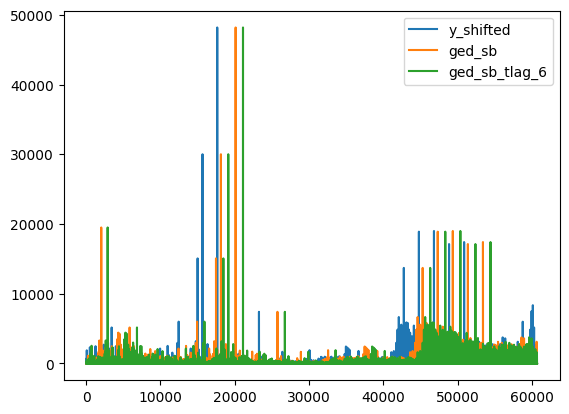

In [681]:
cm_features['y_shifted'] = cm_features.groupby('country_id')['ged_sb'].shift(-15)  # 3 months gap + 12 months prediction
# show na for y_shifted
cm_features[cm_features['y_shifted'].isna()]
# drop na
cm_features = cm_features.dropna()
# plot y_shifted per month
from matplotlib import pyplot as plt

cm_features['y_shifted'].plot()
cm_features['ged_sb'].plot()
cm_features['ged_sb_tlag_6'].plot()
plt.legend()
plt.show()

In [682]:
# drop all ged_sb_tlag_x except for the ged_sb_tlag_6
cm_features = cm_features.drop(columns=['country', 'gleditsch_ward'])
# drop if exists 'year', 'ccode'
cm_features = cm_features.drop(columns=['year', 'ccode'], errors='ignore')

# cm_features = cm_features.drop(
#     columns=['ged_sb_tlag_2', 'ged_sb_tlag_3', 'ged_sb_tlag_4', 'ged_sb_tlag_5', 'ged_sb_tlag_1', 'ged_sb_tlag_6', ])
# # drop ged_sb, ged_ns, ged_os, acled_sb, acled_sb_ count, acled_os, ged_sb_tsum_24
# cm_features = cm_features.drop(
#     columns=['ged_sb', 'ged_ns', 'ged_os', 'acled_sb', 'acled_sb_count', 'acled_os', 'ged_sb_tsum_24', 'ged_os_tlag_1'])
# # drop splag_1_decay_ged_sb_5, splag_1_decay_ged_os_5, splag_1_decay_ged_ns_5, decay_ged_sb_5, decay_ged_os_5, decay_ged_sb_500, decay_ged_os_100, decay_ged_ns_5, decay_ged_ns_100, decay_acled_sb_5, decay_acled_os_5, decay_acled_ns_5
# cm_features = cm_features.drop(
#     columns=['splag_1_decay_ged_sb_5', 'splag_1_decay_ged_os_5', 'splag_1_decay_ged_ns_5', 'decay_ged_sb_5',
#              'decay_ged_os_5', 'decay_ged_sb_500', 'decay_ged_os_100', 'decay_ged_ns_5', 'decay_ged_ns_100',
#              'decay_acled_sb_5', 'decay_acled_os_5', 'decay_acled_ns_5', 'decay_ged_sb_100'])



In [683]:
# save first 50 rows of the dataset to a new csv file with column names
# cm_features.head(50).to_csv('data/cm_features_first_50.csv', index=True)
# cm_features.head(10)
# prepare dataset for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cm_features['date'] = pd.to_datetime(cm_features['date'])
cm_features['country_id'] = cm_features['country_id'].astype('category')
cm_features

,month_id,country_id,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,...,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5,date,gw_statename,y_shifted
0,121,1,0,0,0,0,0,0,0,752897,...,1.380676,3.333333,315260.986388,354505.092577,0.093750,1.034032,0.093750,1990-01-01,Guyana,0.0
1,121,2,0,0,0,0,0,0,0,408360,...,3.922495,2.950609,264606.831667,264606.831667,0.062500,0.062500,0.062500,1990-01-01,Surinam,0.0
2,121,3,0,0,0,0,0,0,0,1256210,...,36.015231,17.956469,3244.939711,3244.939711,0.000000,0.000000,0.000000,1990-01-01,Trinidad and Tobago,0.0
3,121,4,0,0,12,0,0,0,0,19275292,...,26.864392,2.249173,45295.968642,74555.476336,1.062500,1.062500,0.093750,1990-01-01,Venezuela,0.0
4,121,7,0,0,0,0,0,0,0,32165766,...,11.043387,7.800305,9511.721633,28542.982753,0.874154,0.156250,0.156250,1990-01-01,Argentina,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60668,487,242,0,0,0,0,0,0,0,59872579,...,6.594440,12.963241,1583.434859,1814.729450,4.569363,4.371473,2.248713,2020-07-01,Tanzania/Tanganyika,0.0
60669,487,243,0,0,0,0,0,0,0,36304408,...,7.966655,50.751212,825.592620,825.592620,0.911026,0.076540,0.093665,2020-07-01,Morocco,0.0
60670,487,244,0,0,0,0,0,0,0,4383849,...,3.627975,13.246217,96.072254,2738.059240,1.944327,1.130247,1.072989,2020-07-01,Mauritania,0.0
60671,487,245,3,107,12,10,1,50,176,43232093,...,2.478948,118.656388,100.382863,948.618053,6.108470,4.948411,4.582199,2020-07-01,Sudan,3.0


In [684]:
from sklearn.preprocessing import OneHotEncoder

# Define the split date


# features_to_exclude = ['id', 'country', 'ged_sb_tlag_6']
# features = [col for col in cm_features.columns if col not in features_to_exclude]

# X_train = train_df[features]
# y_train = train_df['ged_sb_tlag_6']
# X_test = test_df[features]
# y_test = test_df['ged_sb_tlag_6']
# 
# X_train[features]

In [685]:
# One-hot encode 'country_id'
INCLUDE_COUNTRY_ID = False
if INCLUDE_COUNTRY_ID:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder.fit_transform(cm_features[['country_id']])
    countries_encoded = encoder.transform(cm_features[['country_id']])
    # rename the columns
    countries_encoded = pd.DataFrame(countries_encoded, columns=encoder.get_feature_names_out(['country_id']))
    countries_encoded = countries_encoded.drop(columns='country_id_1')  # drop country_id_1
    # drop na 

    # countries_encoded
    # merge the encoded features with the original dataset
    cm_features = pd.concat([cm_features, countries_encoded], axis=1)
    cm_features = cm_features.dropna()
cm_features

,month_id,country_id,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,...,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5,date,gw_statename,y_shifted
0,121,1,0,0,0,0,0,0,0,752897,...,1.380676,3.333333,315260.986388,354505.092577,0.093750,1.034032,0.093750,1990-01-01,Guyana,0.0
1,121,2,0,0,0,0,0,0,0,408360,...,3.922495,2.950609,264606.831667,264606.831667,0.062500,0.062500,0.062500,1990-01-01,Surinam,0.0
2,121,3,0,0,0,0,0,0,0,1256210,...,36.015231,17.956469,3244.939711,3244.939711,0.000000,0.000000,0.000000,1990-01-01,Trinidad and Tobago,0.0
3,121,4,0,0,12,0,0,0,0,19275292,...,26.864392,2.249173,45295.968642,74555.476336,1.062500,1.062500,0.093750,1990-01-01,Venezuela,0.0
4,121,7,0,0,0,0,0,0,0,32165766,...,11.043387,7.800305,9511.721633,28542.982753,0.874154,0.156250,0.156250,1990-01-01,Argentina,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60668,487,242,0,0,0,0,0,0,0,59872579,...,6.594440,12.963241,1583.434859,1814.729450,4.569363,4.371473,2.248713,2020-07-01,Tanzania/Tanganyika,0.0
60669,487,243,0,0,0,0,0,0,0,36304408,...,7.966655,50.751212,825.592620,825.592620,0.911026,0.076540,0.093665,2020-07-01,Morocco,0.0
60670,487,244,0,0,0,0,0,0,0,4383849,...,3.627975,13.246217,96.072254,2738.059240,1.944327,1.130247,1.072989,2020-07-01,Mauritania,0.0
60671,487,245,3,107,12,10,1,50,176,43232093,...,2.478948,118.656388,100.382863,948.618053,6.108470,4.948411,4.582199,2020-07-01,Sudan,3.0


In [686]:
# Split the dataset into training and test sets
# prediction_year = 2018
# test(final model evaluation): Jan 2018 - Jan 2019
# oct 2016 predicts Jan 2018
# oct 2017 predicts Jan 2019
# thus train set is up until Oct 2016
cut_year = prediction_year - 2  # 2016

features_to_val_oct = pd.Timestamp(year=cut_year - 1, month=10, day=1)  # 2016-Oct-01
features_to_oct = pd.Timestamp(year=cut_year, month=10, day=1)  # 2016-Oct-01

# Splitting the dataset
CREATE_VAL_DS = False
if CREATE_VAL_DS:
    train_df = cm_features[cm_features['date'] < features_to_val_oct]  # train is till Sep 2015
    validation_df = cm_features[
        (cm_features['date'] >= features_to_val_oct) &  # oct 2015 predicts Jan 2017
        (cm_features['date'] < features_to_oct)]
else:
    train_df = cm_features[cm_features['date'] < features_to_oct]  # train is till Sep 2016
# test_df is one year from Oct 2016 to Oct 2017
test_df = cm_features[
    (cm_features['date'] >= features_to_oct) &  # oct 2016 predicts Jan 2018
    (cm_features['date'] < pd.Timestamp(year=prediction_year - 1, month=10, day=1))]  # oct 2017 predicts Jan 2019

In [687]:
# count number of rows where y_shifted is 0
# drop 0 rows from train df 
DROP_0_ROWS_PERCENT = 80
print(f"Initial count: {train_df[train_df['y_shifted'] == 0].shape[0]}")
indices = train_df[train_df['y_shifted'] == 0].index.to_series()
num_to_drop = int(len(indices) * DROP_0_ROWS_PERCENT / 100)
indices_to_drop = indices.sample(n=num_to_drop, random_state=42)
train_df = train_df.drop(indices_to_drop)
print(f"Count after removal: {train_df[train_df['y_shifted'] == 0].shape[0]}")
test_df.reset_index(drop=True, inplace=True)

Initial count: 45161
Count after removal: 9033


In [688]:
# shuffle the training set
# train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [689]:
# save date column for test_df
test_df_date = test_df['date']
train_df_date = train_df['date']
test_df_country_name = test_df['gw_statename']
train_df_country_name = train_df['gw_statename']
train_df_country_id = train_df['country_id']
test_df_country_id = test_df['country_id']
train_df_month_id = train_df['month_id']
test_df_month_id = test_df['month_id']

test_df = test_df.drop('date', axis=1)
test_df = test_df.drop("country_id", axis=1)
test_df = test_df.drop("gw_statename", axis=1)

if CREATE_VAL_DS:
    val_df_date = validation_df['date']
    val_df_country_id = validation_df['country_id']
    val_df_month_id = validation_df['month_id']
    validation_df = validation_df.drop('date', axis=1)
    validation_df = validation_df.drop("country_id", axis=1)
    validation_df = validation_df.drop("gw_statename", axis=1)

train_df = train_df.drop('date', axis=1)
train_df = train_df.drop("country_id", axis=1)
train_df = train_df.drop("gw_statename", axis=1)

INCLUDE_MONTH_ID = False
if not INCLUDE_MONTH_ID:
    test_df = test_df.drop('month_id', axis=1)
    train_df = train_df.drop('month_id', axis=1)
    if CREATE_VAL_DS:
        validation_df = validation_df.drop('month_id', axis=1)

print(test_df_month_id.unique())
print("Difference between bechmark and test month_id:")
print(benchmark_model['month_id'].min() - test_df_month_id.min())

train_df.head(200)

[442 443 444 445 446 447 448 449 450 451 452 453]
Difference between bechmark and test month_id:
15


,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,ged_sb_tlag_2,...,irr_agr_efficiency_t48,services_efficiency_t48,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5,y_shifted
2,0,0,0,0,0,0,0,1256210,0,0,...,1.671158,35.755839,36.015231,17.956469,3244.939711,3244.939711,0.000000,0.000000,0.000000,0.0
9,0,0,0,0,0,0,150,3951288,0,0,...,0.126870,109.743265,10.664287,0.327071,30927.230078,102501.299208,0.093750,0.093750,0.093750,0.0
10,40,0,46,0,0,0,1867,21624311,104,50,...,0.442221,28.704283,8.900749,2.526080,81115.613030,92919.640082,1.125000,1.125000,0.156250,62.0
11,0,0,0,0,0,0,0,3097889,0,0,...,0.153866,46.349818,8.671929,6.566845,30422.526660,56819.512916,0.062500,0.062500,0.062500,0.0
12,4,0,4,0,0,0,86,8805995,17,3,...,0.822689,152.263548,13.320578,4.193121,12940.529026,15157.720400,1.118181,0.149431,0.149431,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,0,0,0,0,0,0,0,19145077,0,0,...,0.442078,15.104540,1.377351,8.369071,11496.737786,12192.806673,2.000000,1.749154,1.027841,0.0
653,0,0,0,0,0,0,0,123069000,0,0,...,0.910367,111.488664,37.080917,41.323218,3509.942856,3509.942856,0.000000,0.000000,0.000000,0.0
655,121,0,0,0,0,0,1725,60127343,288,132,...,0.109528,13.423477,2.108009,24.118007,8591.103043,8591.103043,0.000000,0.000000,0.000000,31.0
659,6,0,0,0,0,0,1501,39489419,172,64,...,0.043032,7.883600,0.140370,4.932961,25913.161142,30176.894277,4.886938,3.693998,1.111362,4.0


In [690]:
target = 'y_shifted'
X_train = train_df.drop(target, axis=1)
y_train = train_df[target]

if CREATE_VAL_DS:
    X_val = validation_df.drop(target, axis=1)
    y_val = validation_df[target]

X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

In [691]:
y_train

2         0.0
9         0.0
10       62.0
11        0.0
12        4.0
         ... 
52892     0.0
52893     6.0
52894     0.0
52897     4.0
52898    62.0
Name: y_shifted, Length: 15977, dtype: float64

In [692]:
# assert month_id, country_id, date are not in the features
# assert 'month_id' not in X_train.columns
print('month_id' in X_train.columns)
X_test

False


,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,ged_sb_tlag_2,...,ind_efficiency_t48,irr_agr_efficiency_t48,services_efficiency_t48,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5
0,0,0,0,0,0,0,0,755031,0,0,...,41.965579,0.125736,20.383693,1.576103,3.298402,319036.694515,358750.805866,0.000265,1.060724,0.929863
1,0,0,0,0,0,0,0,575475,0,0,...,11.840596,0.934625,48.234420,7.120108,3.950609,182911.620431,182911.620431,0.000006,0.118033,0.686980
2,0,0,0,0,0,0,0,1460177,0,0,...,86.825329,1.622908,52.342918,61.731641,20.326481,2855.402846,2855.402846,0.000000,0.000000,0.000000
3,0,0,2,0,0,0,0,30529716,0,0,...,213.283572,0.445294,33.185070,15.320483,7.540367,27417.474509,45128.141272,0.890905,0.563483,0.712510
4,0,0,0,0,0,0,0,43131966,0,0,...,36.670942,0.119870,58.861236,13.085494,10.456664,6993.141644,20985.172720,0.000082,0.060733,0.690568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,0,0,0,0,0,3,0,54401802,0,0,...,412.971789,0.132565,33.875609,5.553777,12.963241,1732.561444,1985.639169,3.509679,4.837398,2.607859
2024,0,0,0,0,1,0,0,35107264,0,0,...,106.996363,0.380566,46.472747,7.244581,50.751212,860.133333,860.133333,1.121441,0.204336,0.250054
2025,0,0,0,0,0,0,0,4051890,0,0,...,56.575372,0.200425,23.185089,3.152180,13.246217,104.780780,2986.252238,2.210346,1.319249,1.270859
2026,19,0,9,22,6,29,1551,39377169,0,0,...,161.387656,0.203982,38.842079,2.015564,118.656388,107.896543,1019.622335,6.239003,5.073056,4.485709


In [693]:
from ngboost.scores import CRPScore, LogScore
from ngboost.distns import Poisson, Normal, MultivariateNormal, Gamma
from ngboost import NGBRegressor

# supress RuntimeWarning for NGBRegressor
import warnings

normal_enabled = True
if normal_enabled:
    n_estimators = 300
else:
    n_estimators = 500
score = LogScore
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print(f"Training NGB with {n_estimators} estimators and {score} score...")
    ngb = NGBRegressor(n_estimators=n_estimators, verbose_eval=10, Dist=Normal if normal_enabled else Poisson,
                       Score=score,
                       early_stopping_rounds=None).fit(
        X_train, y_train,
        X_val if CREATE_VAL_DS else X_test, y_val if CREATE_VAL_DS else y_test)
ngb_train_predictions = ngb.predict(X_train)
ngb_predictions = ngb.predict(X_test)
ngb_predictions_dist = ngb.pred_dist(X_test)
# means and stds of the predictions
# mean, std = ngb_predictions_dist.loc, ngb_predictions_dist.scale

ngb_train_predictions = [max(0, pred) for pred in ngb_train_predictions]
ngb_predictions = [max(0, pred) for pred in ngb_predictions]
print("Done!")

Training NGB with 300 estimators and <class 'ngboost.scores.LogScore'> score...
[iter 0] loss=7.8697 val_loss=7.4220 scale=0.1250 norm=14.5276
[iter 10] loss=7.3667 val_loss=7.3273 scale=2.0000 norm=218.7249
[iter 20] loss=7.2711 val_loss=7.2354 scale=2.0000 norm=204.9881
[iter 30] loss=7.1802 val_loss=7.1418 scale=2.0000 norm=194.1075
[iter 40] loss=7.0931 val_loss=7.0520 scale=2.0000 norm=184.6867
[iter 50] loss=7.0047 val_loss=6.9604 scale=2.0000 norm=177.9927
[iter 60] loss=6.9203 val_loss=6.8689 scale=2.0000 norm=172.4027
[iter 70] loss=6.8367 val_loss=6.7765 scale=2.0000 norm=167.2078
[iter 80] loss=6.7543 val_loss=6.6877 scale=2.0000 norm=161.0519
[iter 90] loss=6.6737 val_loss=6.5992 scale=2.0000 norm=154.7771
[iter 100] loss=6.5934 val_loss=6.5122 scale=2.0000 norm=148.5707
[iter 110] loss=6.5077 val_loss=6.4205 scale=2.0000 norm=143.2480
[iter 120] loss=6.4308 val_loss=6.3374 scale=2.0000 norm=138.6101
[iter 130] loss=6.3586 val_loss=6.2488 scale=4.0000 norm=268.9702
[iter 14

In [694]:
# map predictions to months based on the test_df
# test_df['predictions'] = xg_lss_pred
test_df['ngb_predictions'] = ngb_predictions
# train_df['predictions'] = xg_lss_pred_train
train_df['ngb_predictions'] = ngb_train_predictions

# add date column back to test_df and add to each date shift of 15 months
test_df['date'] = test_df_date + pd.DateOffset(months=15)
train_df['date'] = train_df_date
test_df['country_id'] = test_df_country_id
train_df['country_id'] = train_df_country_id
test_df['month_id'] = test_df_month_id
train_df['month_id'] = train_df_month_id
test_df['country_name'] = test_df_country_name
train_df['country_name'] = train_df_country_name

# test_df

In [695]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# TODO: Improve metrics and use all metrics from the VIEWS competition
# Calculate RMSE
# train_rmse = sqrt(mean_squared_error(y_train, xg_lss_pred_train))
ngb_train_rmse = sqrt(mean_squared_error(y_train, ngb_train_predictions))

ngb_test_rmse = sqrt(mean_squared_error(y_test, ngb_predictions))
all_zeros_rmse = sqrt(mean_squared_error(y_test, [0] * len(y_test)))
# actuals_rmse = sqrt(mean_squared_error(actuals_model['ged_sb'], predictions))
# benchmark_rmse = sqrt(mean_squared_error(y_test, benchmark_model['outcome']))
actuals_bench_rmse = sqrt(mean_squared_error(actuals_model['ged_sb'], benchmark_model['outcome']))

print(f"Prediction year: {prediction_year}")
print(f"Include country_id: {INCLUDE_COUNTRY_ID}")
print(f"Include month_id: {INCLUDE_MONTH_ID}")
print(f"Drop train 0 rows: {DROP_0_ROWS_PERCENT}%")
print(f"Normal distribution: {normal_enabled}")
print(f"Number of estimators: {n_estimators}")
print(f"Score: {str(score)}")

# TODO: Improve metrics and use all metrics from the VIEWS competition
# print(f"XGB [train predictions] RMSE: {train_rmse}")
# print(f"XGB [test predictions]  RMSE YTEST VS PREDICTIONS: {rmse}")

print(f"\nNGB [train predictions] RMSE NGB: {ngb_train_rmse}")
if CREATE_VAL_DS:
    ngb_val_rmse = sqrt(mean_squared_error(y_val, ngb.predict(X_val)))
    print(f"NGB [validation predictions] RMSE NGB: {ngb_val_rmse}")
print(f"NGB [test predictions]  RMSE NGB: {ngb_test_rmse}")
# print(f"RMSE YTEST VS ACTUALS: {actuals_rmse}")
# print(f"RMSE YTEST VS BENCHMARK: {benchmark_rmse}")
print(f"All Zeros: {all_zeros_rmse}")
print(f"\nBenchmark: RMSE ACTUALS VS BENCHMARK: {actuals_bench_rmse}")

Prediction year: 2018
Include country_id: False
Include month_id: False
Drop train 0 rows: 80%
Normal distribution: True
Number of estimators: 300
Score: <class 'ngboost.scores.LogScore'>

NGB [train predictions] RMSE NGB: 267.7973564729484
NGB [test predictions]  RMSE NGB: 155.79675106036618
All Zeros: 202.44434182871484

Benchmark: RMSE ACTUALS VS BENCHMARK: 145.02118862282583


In [696]:
# https://stanfordmlgroup.github.io/ngboost/3-interpretation.html
# DO_IMPORTANCE = False
# # print all feature importance sorted
# feature_importance = bst.get_fscore()
# feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
# print(feature_importance)
# 
# if DO_IMPORTANCE:
#     from xgboost import plot_importance
# 
#     # plot
#     plot_importance(bst, max_num_features=10)
#     plt.show()
# 
#     import shap
# 
#     explainer = shap.TreeExplainer(bst)
#     # dtrain = xgb.DMatrix(X_train, label=y_train)
#     dtrain.feature_names = X_train.columns.tolist()
#     explanation = explainer(dtrain)
#     explanation = shap.Explanation(
#         values=explanation.values,
#         base_values=explanation.base_values,
#         data=explanation.data,
#         feature_names=X_train.columns.tolist()
#     )
#     shap.plots.beeswarm(explanation)
# 


In [697]:
# for each timeseries plot the actual and predicted values
import matplotlib.pyplot as plt
# map back id to country name
# country_id = index + 1
# y_test.reset_index(inplace=True, drop=True)
# y_test = y_test.to_frame()
# y_test['country_id'] = y_test.index + 1



In [698]:
# map country_id to country name
# country_list = pd.read_csv('data/country_list.csv') 
# country_list
# y_test["country_name"] = y_test["country_id"].map(country_list.set_index('country_id')['name'])
# y_test
# dir(ngb.pred_dist(X_test).dist)

In [699]:
# dir(ngb.pred_dist(X_test))
# sample dist 1000 times and calculate the std per each row
# ngb.pred_dist(X_test).var
# ngb_predictions_std = ngb_predictions_dist.sample(1000).std(axis=0)
# ngb_predictions_std

In [700]:
PLOT_STD = True
if PLOT_STD:
    import numpy as np

    dir(ngb.pred_dist(X_test).scale)
    # ngb.pred_dist(X_test).
    # save std of the predictions
    if normal_enabled:
        ngb_predictions_std = np.sqrt(ngb_predictions_dist.var)
    else:
        sampled_dist = ngb_predictions_dist.sample(1000)
        ngb_predictions_std = sampled_dist.std(axis=0)
        ngb_predictions_max = sampled_dist.max(axis=0)
        ngb_predictions_min = sampled_dist.min(axis=0)
    # add std to test_df
    test_df['ngb_predictions_std'] = ngb_predictions_std
    test_df['ngb_predictions_max'] = ngb_predictions_max
    test_df['ngb_predictions_min'] = ngb_predictions_min


Unique months: [442 443 444 445 446 447 448 449 450 451 452 453]


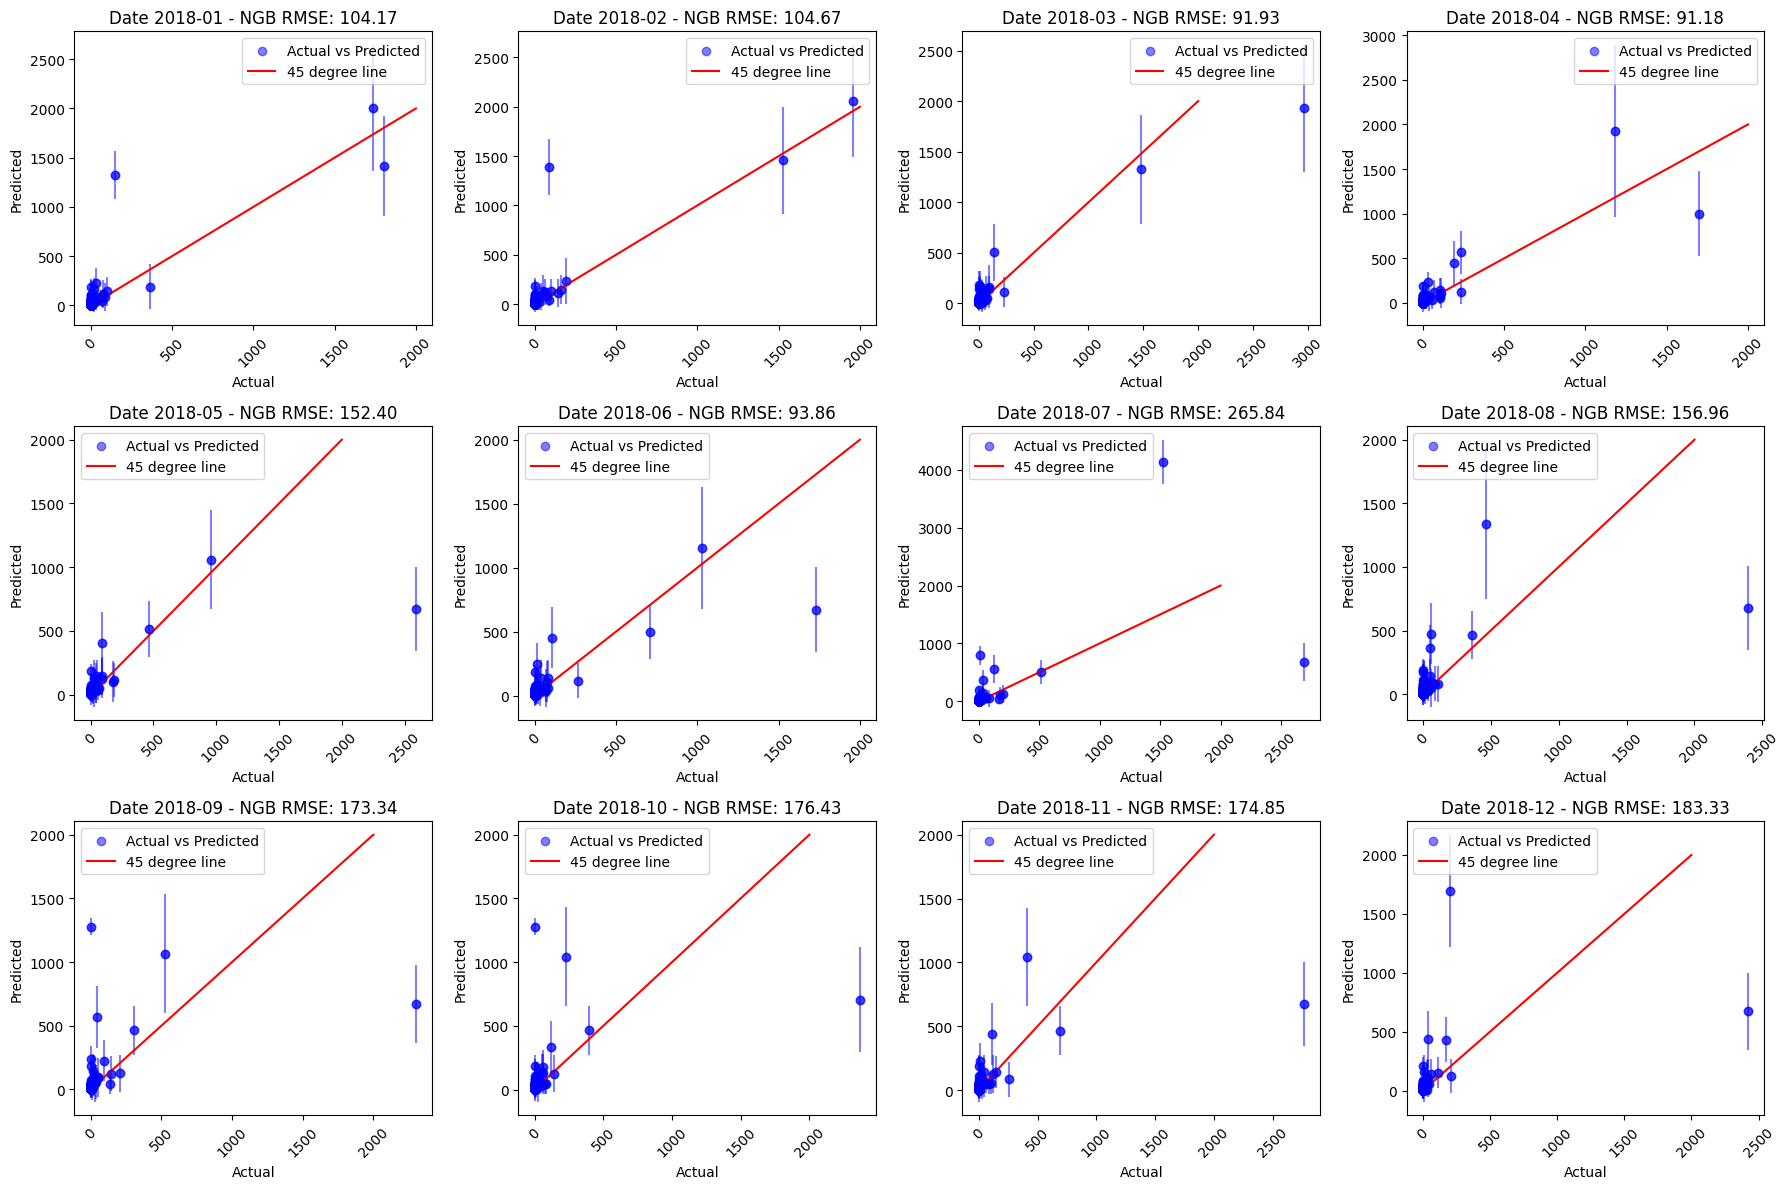

In [701]:
import matplotlib.pyplot as plt

# Assuming test_df is your DataFrame, and 'target' and 'predictions' are columns in it
unique_months = test_df['month_id'].unique()
n_months = len(unique_months)
print("Unique months:", unique_months)

# Calculate the grid size for the subplot (simple square root approximation for a square grid)
grid_size_x = int(n_months ** 0.5) + (1 if n_months % int(n_months ** 0.5) else 0)
grid_size_y = grid_size_x + 1

# print(f'Grid size: {grid_size}')
# Set overall figure size
plt.figure(figsize=(grid_size_x * 6, grid_size_y * 3))  # Adjust the size factors (6, 4) based on your preference

for index, month_id in enumerate(unique_months, start=1):
    this_month = test_df[test_df['month_id'] == month_id]
    mean_sq_error = sqrt(mean_squared_error(this_month[target], this_month['ngb_predictions']))
    current_date = this_month["date"].iloc[0]
    target_month = this_month[target]
    predictions_month = this_month['ngb_predictions']

    # Create subplot for current month
    plt.subplot(grid_size_x, grid_size_y, index)
    plt.scatter(target_month, predictions_month, color='blue', label='Actual vs Predicted', alpha=0.5)

    if PLOT_STD:
        predictions_std_month = this_month['ngb_predictions_std']
        plt.errorbar(target_month, predictions_month, yerr=predictions_std_month, fmt='o', color='blue', alpha=0.5)

    # print current_date in YY/MM format
    print_date = current_date.strftime('%Y-%m')
    plt.title(f'Date {print_date} - NGB RMSE: {mean_sq_error:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.plot([0, 2000], [0, 2000], color='red', label='45 degree line')
    plt.legend()
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [702]:
country_list = pd.read_csv('data/country_list.csv')
# get observations with the highest error
# calculate the error
test_df['error'] = abs(test_df[target] - test_df['ngb_predictions'])
temp_df = test_df.sort_values(by='error', ascending=False)
highest_error_indices = temp_df.head(10).index
del temp_df
# highest_error_indices

# get the highest error
highest_error = test_df.nlargest(30, 'error')
# drop columns that contain 'country_id_'
highest_error = highest_error[highest_error.columns.drop(list(highest_error.filter(regex='country_id_')))]
# add country name
highest_error = highest_error.merge(country_list, on='country_id')
highest_error
# from the test_df get sorted by highest, get the first 10 


,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,ged_sb_tlag_2,...,date,country_id,month_id,country_name,ngb_predictions_std,ngb_predictions_max,ngb_predictions_min,error,id,name
0,2065,860,72,1726,1621,2077,93180,18964252,2455,2079,...,2018-07-01,220,448,Syria,386.601879,539,404,2611.914698,220,Syria
1,2718,882,85,2562,1486,1922,85149,18964252,1561,1634,...,2018-12-01,220,453,Syria,477.434661,494,365,1492.866801,220,Syria
2,17412,383,55,0,0,0,96014,19205178,2967,2127,...,2018-03-01,220,444,Syria,628.464806,691,541,1034.720676,220,Syria
3,1393,1315,204,1393,1050,1686,90181,18964252,2065,2455,...,2018-08-01,220,449,Syria,587.271860,552,395,872.379567,220,Syria
4,1634,1243,49,1592,1128,1305,87042,18964252,1385,1393,...,2018-10-01,220,451,Syria,386.601879,561,420,815.229901,220,Syria
5,1714,559,63,2012,1702,1973,95204,18964252,17412,2967,...,2018-04-01,220,445,Syria,962.896142,577,428,750.238007,220,Syria
6,1561,1410,23,2391,1521,1488,85196,18964252,1634,1385,...,2018-11-01,220,452,Syria,386.601879,497,372,635.229901,220,Syria
7,1385,1113,48,1928,1225,1608,88334,18964252,1393,2065,...,2018-09-01,220,450,Syria,468.313853,542,405,536.654650,220,Syria
8,2127,755,13,0,0,0,98298,19205178,2285,2308,...,2018-01-01,220,442,Syria,510.343005,579,439,383.587886,220,Syria
9,2217,32,79,2416,969,178,37172,34636207,2465,921,...,2018-11-01,133,452,Afghanistan,329.004507,419,292,2095.203000,133,Afghanistan


Max date in training set: 2016-09-01 00:00:00
Min date in test set: 2018-01-01 00:00:00
Expected min date in test set: 2018-01-01 00:00:00
Skipping Guyana as all actual are 0
Skipping Suriname as all actual are 0
Skipping Trinidad and Tobago as all actual are 0
Skipping Venezuela as all actual are 0
Skipping Argentina as all actual are 0
Skipping Bolivia as all actual are 0
Skipping Brazil as all actual are 0
Skipping Chile as all actual are 0
Skipping Ecuador as all actual are 0
Skipping Paraguay as all actual are 0
Skipping Peru as all actual are 0
Skipping Uruguay as all actual are 0
Skipping Guatemala as all actual are 0
Skipping Mexico as all actual are 0
Skipping Barbados as all actual are 0
Skipping Dominican Republic as all actual are 0
Skipping Haiti as all actual are 0
Skipping Jamaica as all actual are 0
Skipping Costa Rica as all actual are 0
Skipping Cuba as all actual are 0
Skipping El Salvador as all actual are 0
Skipping Honduras as all actual are 0
Skipping Nicaragua a

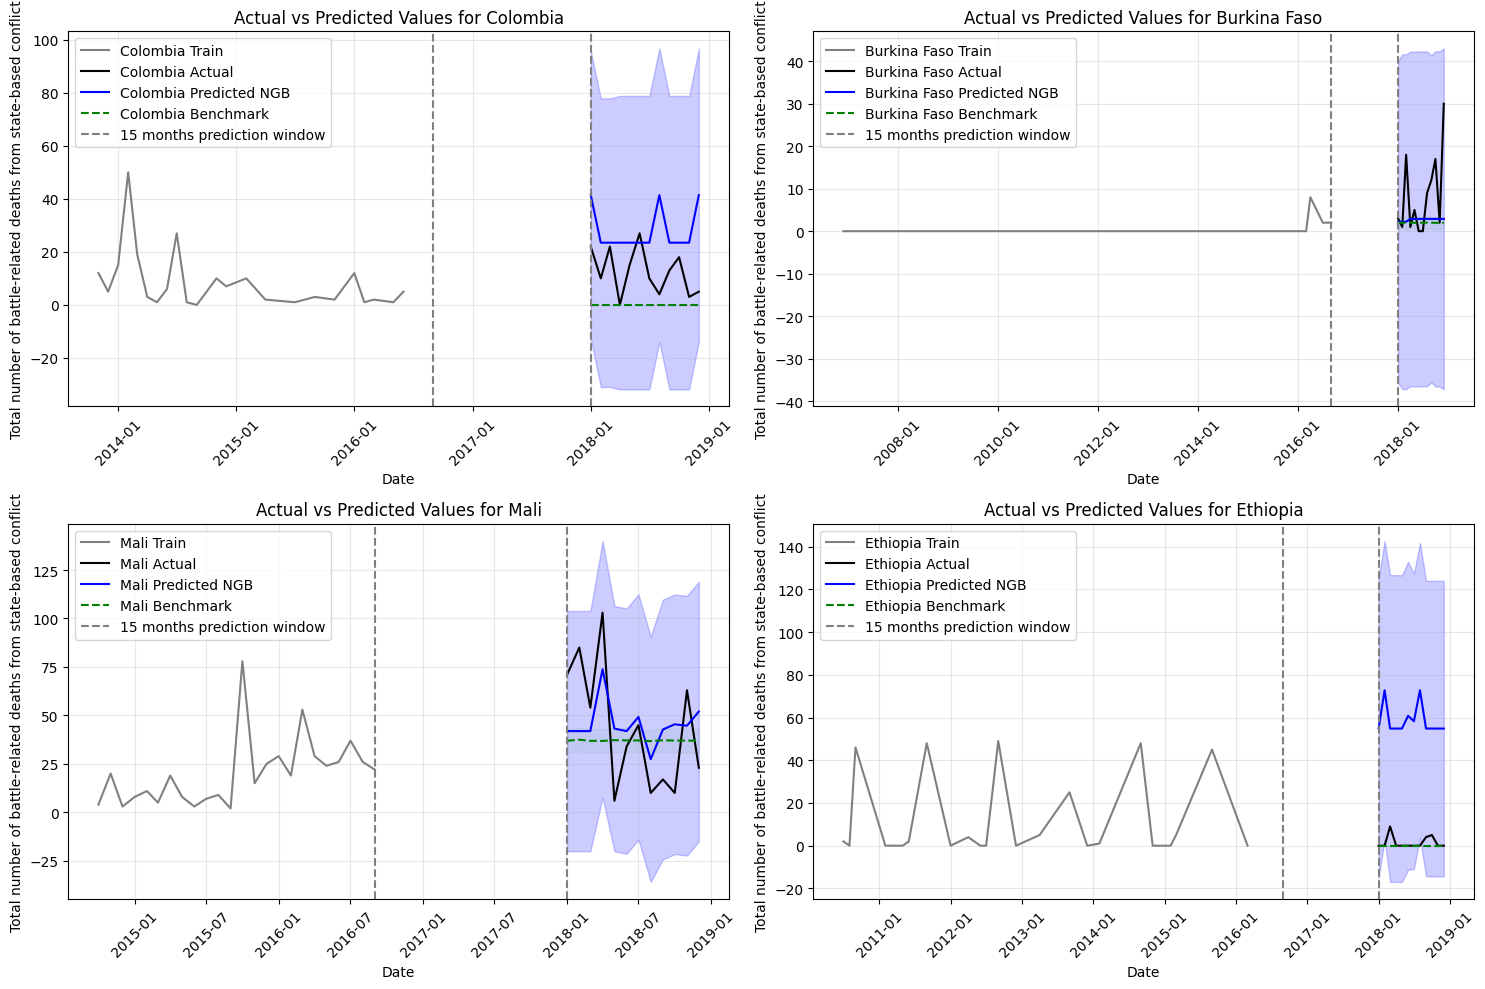

Skipping Mongolia as all actual are 0
Skipping Jordan as all actual are 0
Skipping Kazakhstan as all actual are 0
Skipping Norway as all actual are 0
Skipping Sweden as all actual are 0


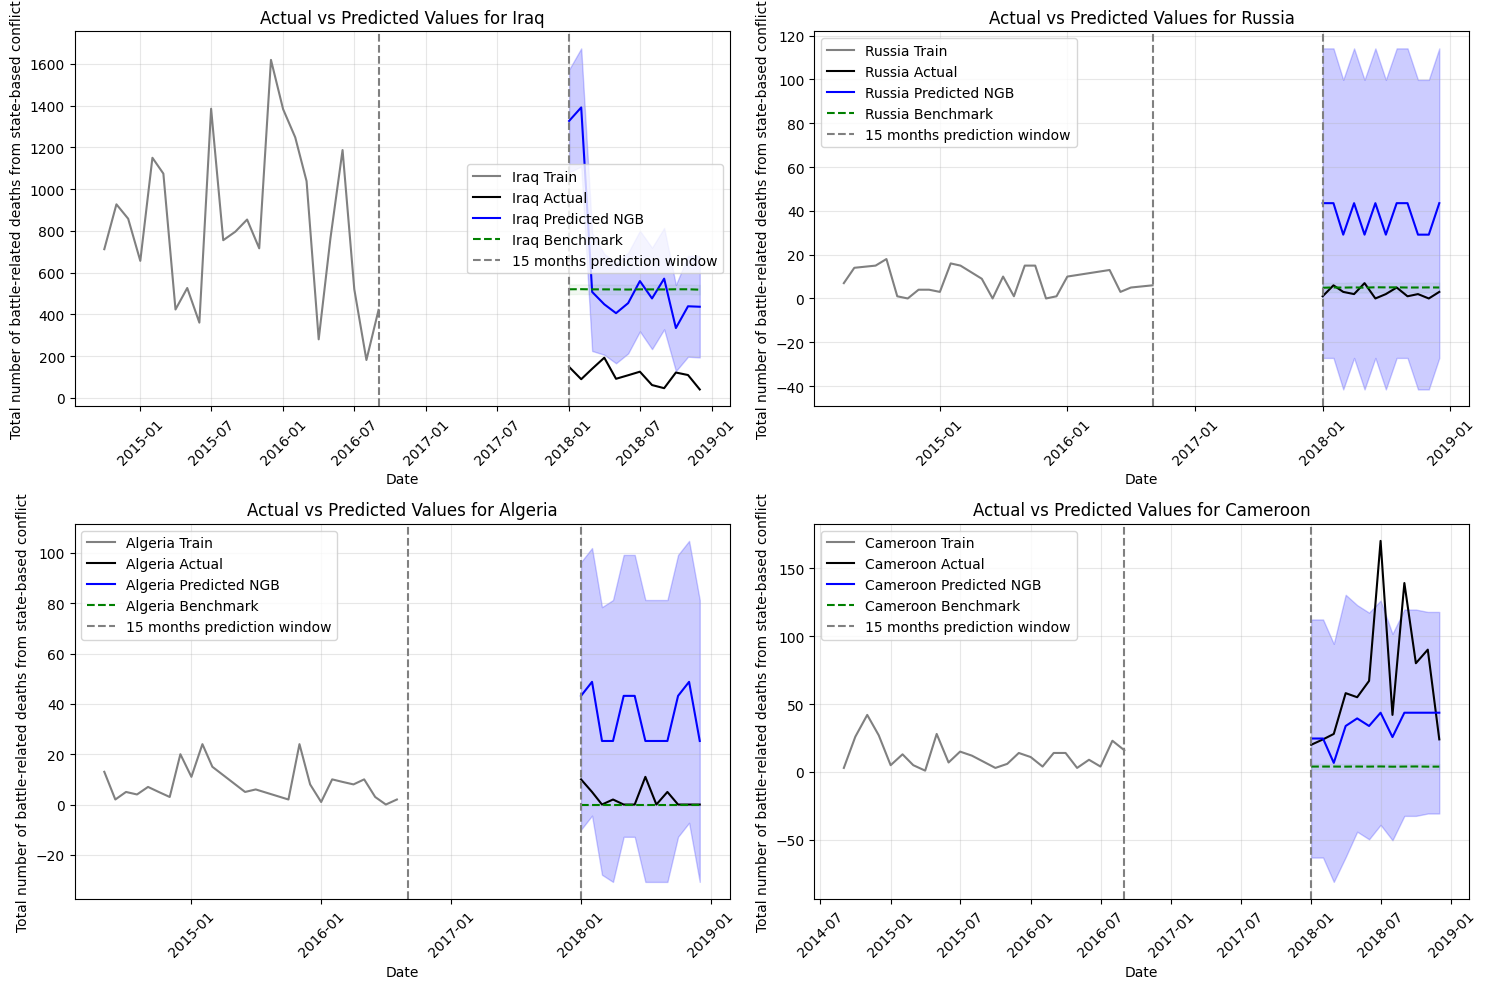

Skipping Benin as all actual are 0
Skipping Equatorial Guinea as all actual are 0


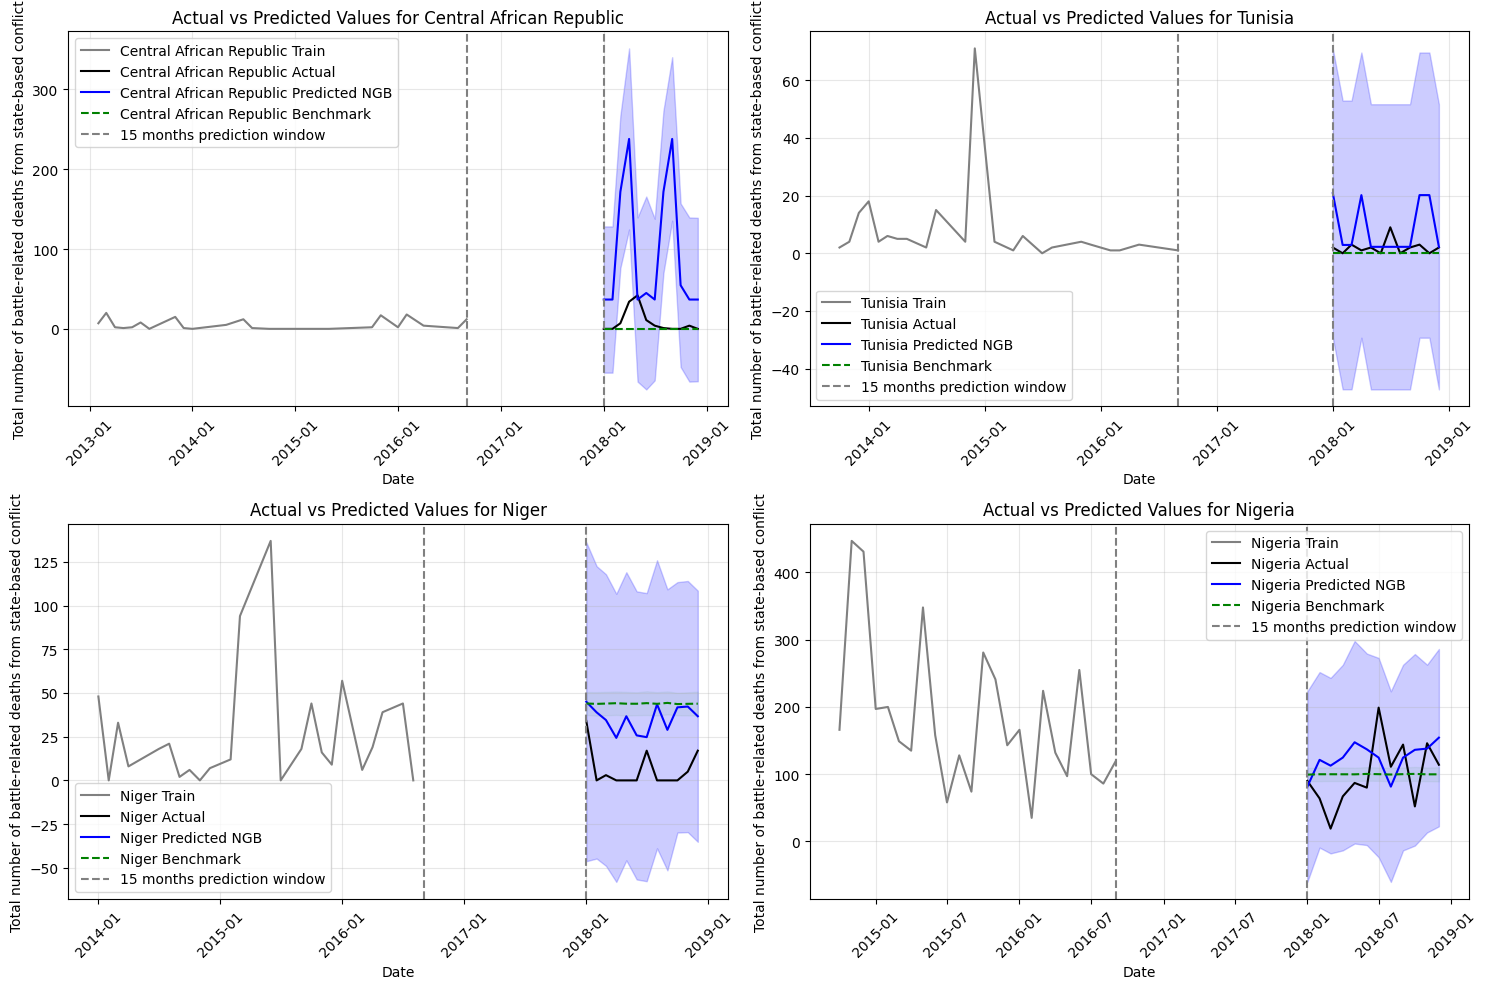

Skipping Togo as all actual are 0
Skipping Albania as all actual are 0
Skipping Bosnia and Herzegovina as all actual are 0
Skipping Croatia as all actual are 0
Skipping Italy as all actual are 0
Skipping Macedonia as all actual are 0
Skipping Malta as all actual are 0
Skipping Bulgaria as all actual are 0
Skipping Cyprus as all actual are 0
Skipping Georgia as all actual are 0
Skipping Greece as all actual are 0
Skipping Austria as all actual are 0
Skipping Czech Republic as all actual are 0
Skipping Denmark as all actual are 0
Skipping Hungary as all actual are 0
Skipping Poland as all actual are 0
Skipping Slovakia as all actual are 0
Skipping Slovenia as all actual are 0


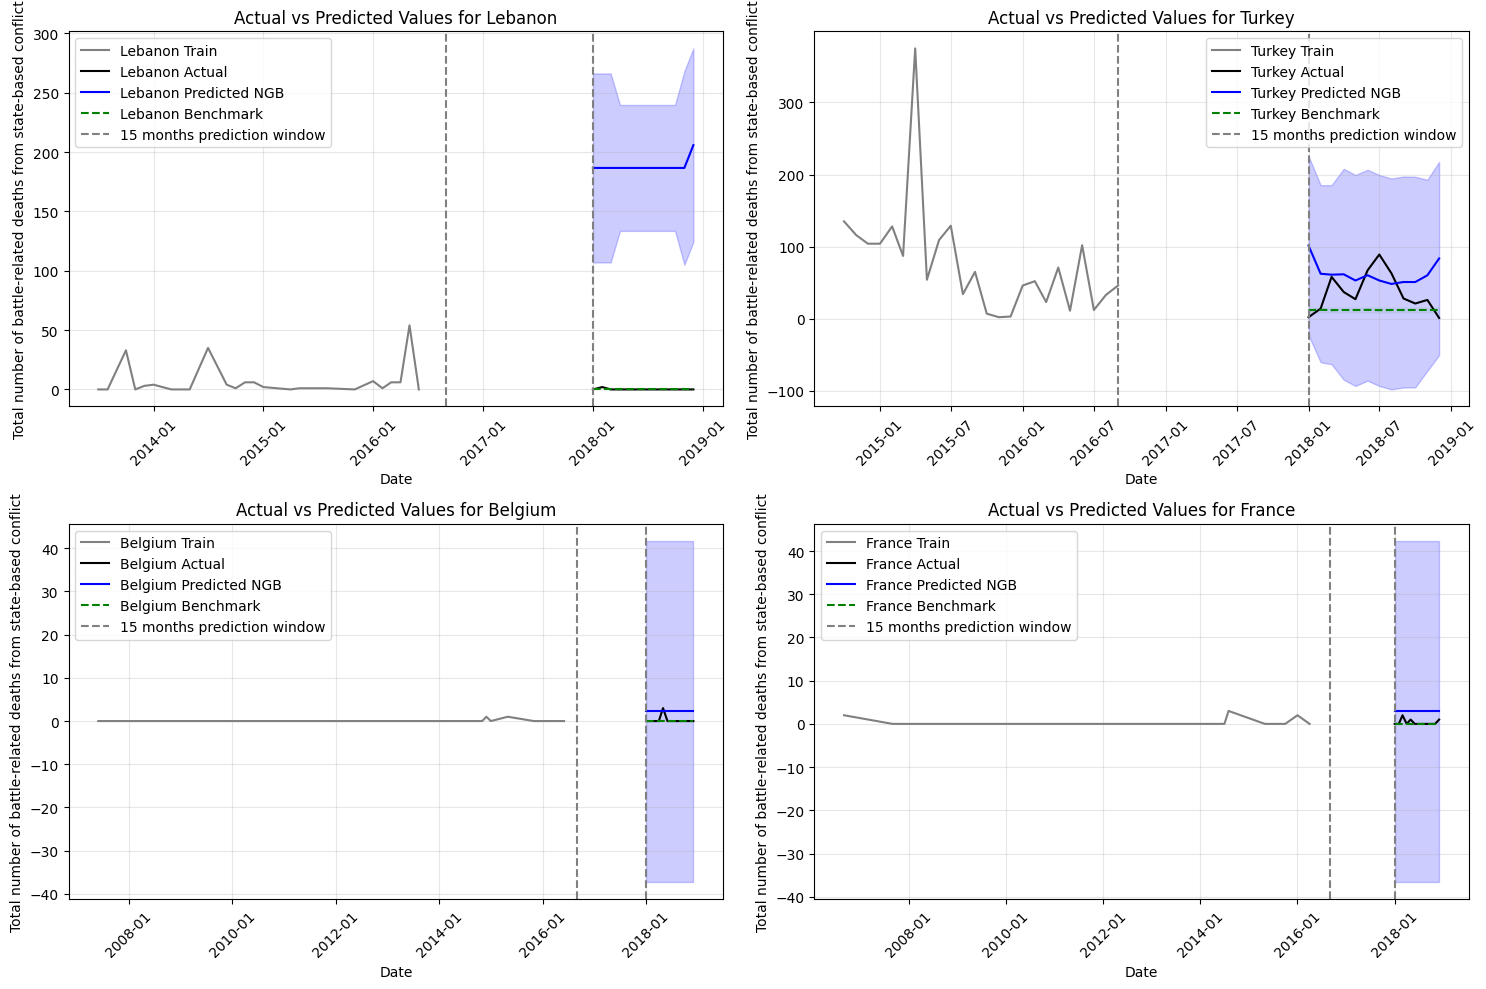

Skipping Luxembourg as all actual are 0
Skipping Netherlands as all actual are 0
Skipping Switzerland as all actual are 0
Skipping Belarus as all actual are 0
Skipping Estonia as all actual are 0
Skipping Finland as all actual are 0
Skipping Latvia as all actual are 0
Skipping Lithuania as all actual are 0
Skipping Moldova as all actual are 0
Skipping Romania as all actual are 0
Skipping Maldives as all actual are 0
Skipping Oman as all actual are 0
Skipping Sri Lanka as all actual are 0
Skipping Turkmenistan as all actual are 0
Skipping Uzbekistan as all actual are 0


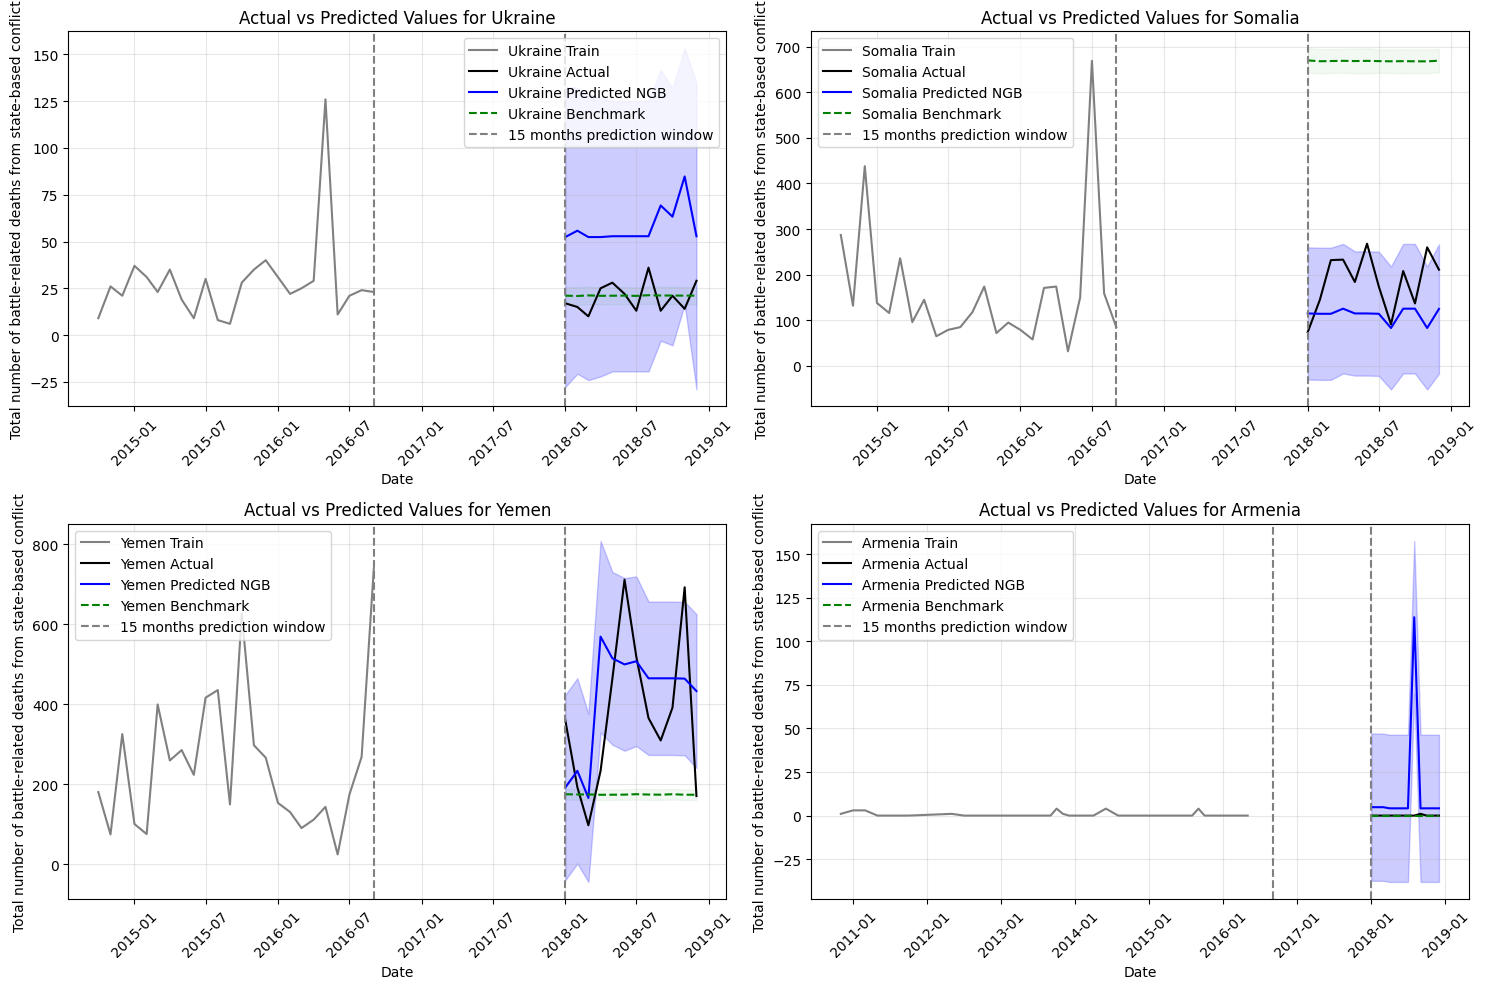

Skipping Bahrain as all actual are 0
Skipping Kuwait as all actual are 0
Skipping Qatar as all actual are 0
Skipping United Arab Emirates as all actual are 0


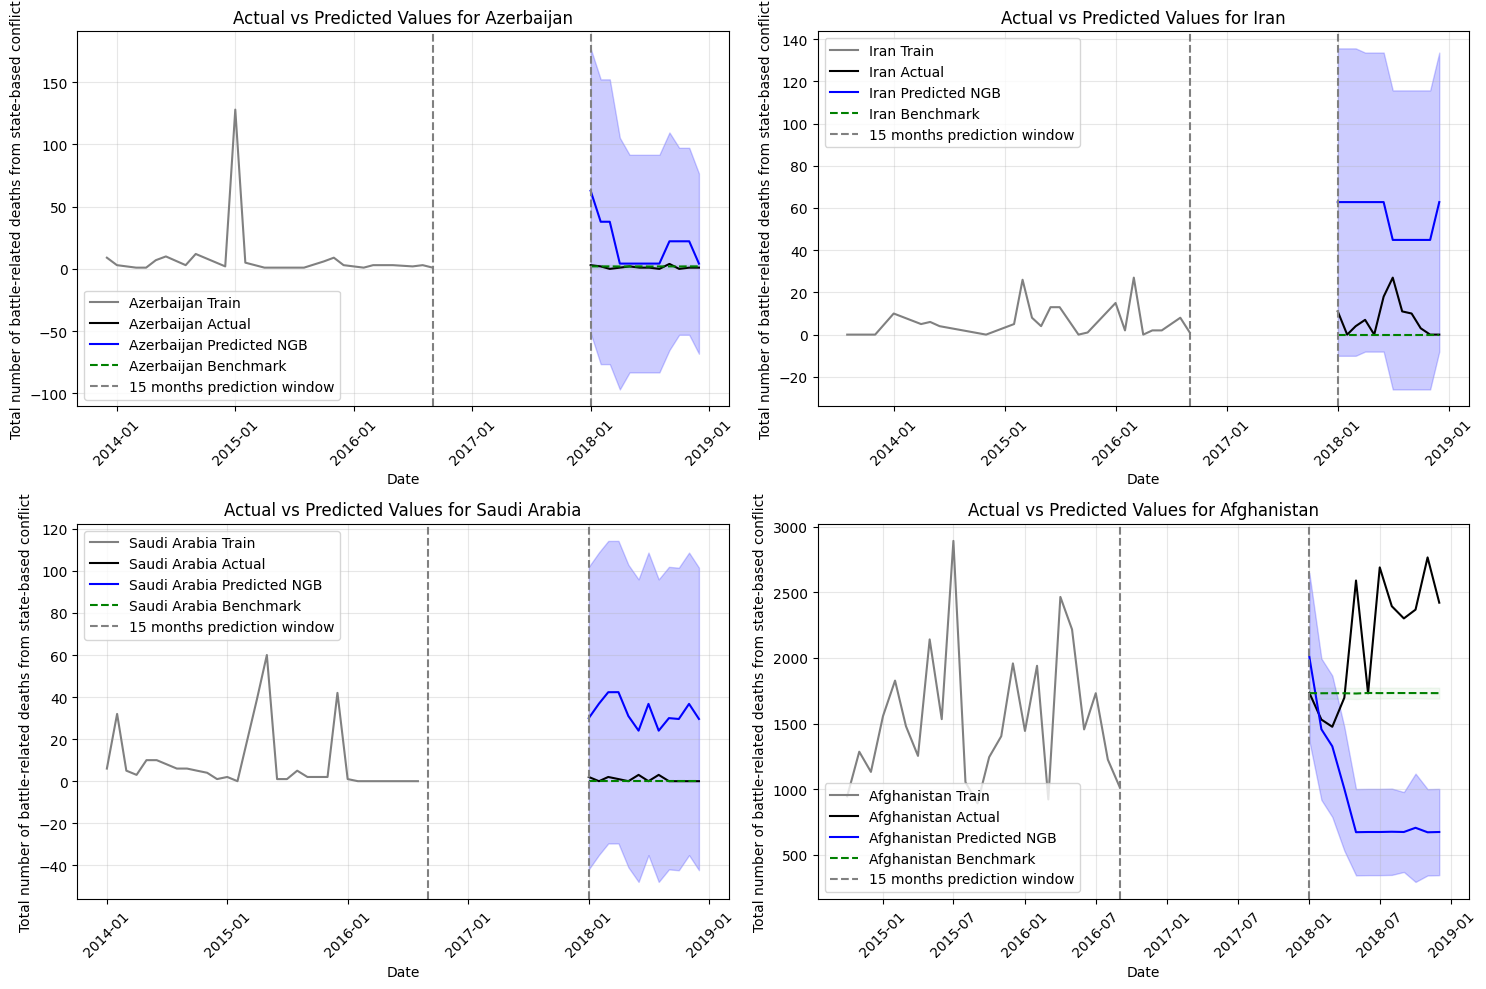

Skipping Kyrgyzstan as all actual are 0
Skipping Nepal as all actual are 0
Skipping Tajikistan as all actual are 0
Skipping Bhutan as all actual are 0
Skipping Japan as all actual are 0
Skipping North Korea as all actual are 0
Skipping South Korea as all actual are 0
Skipping Cambodia as all actual are 0
Skipping Laos as all actual are 0


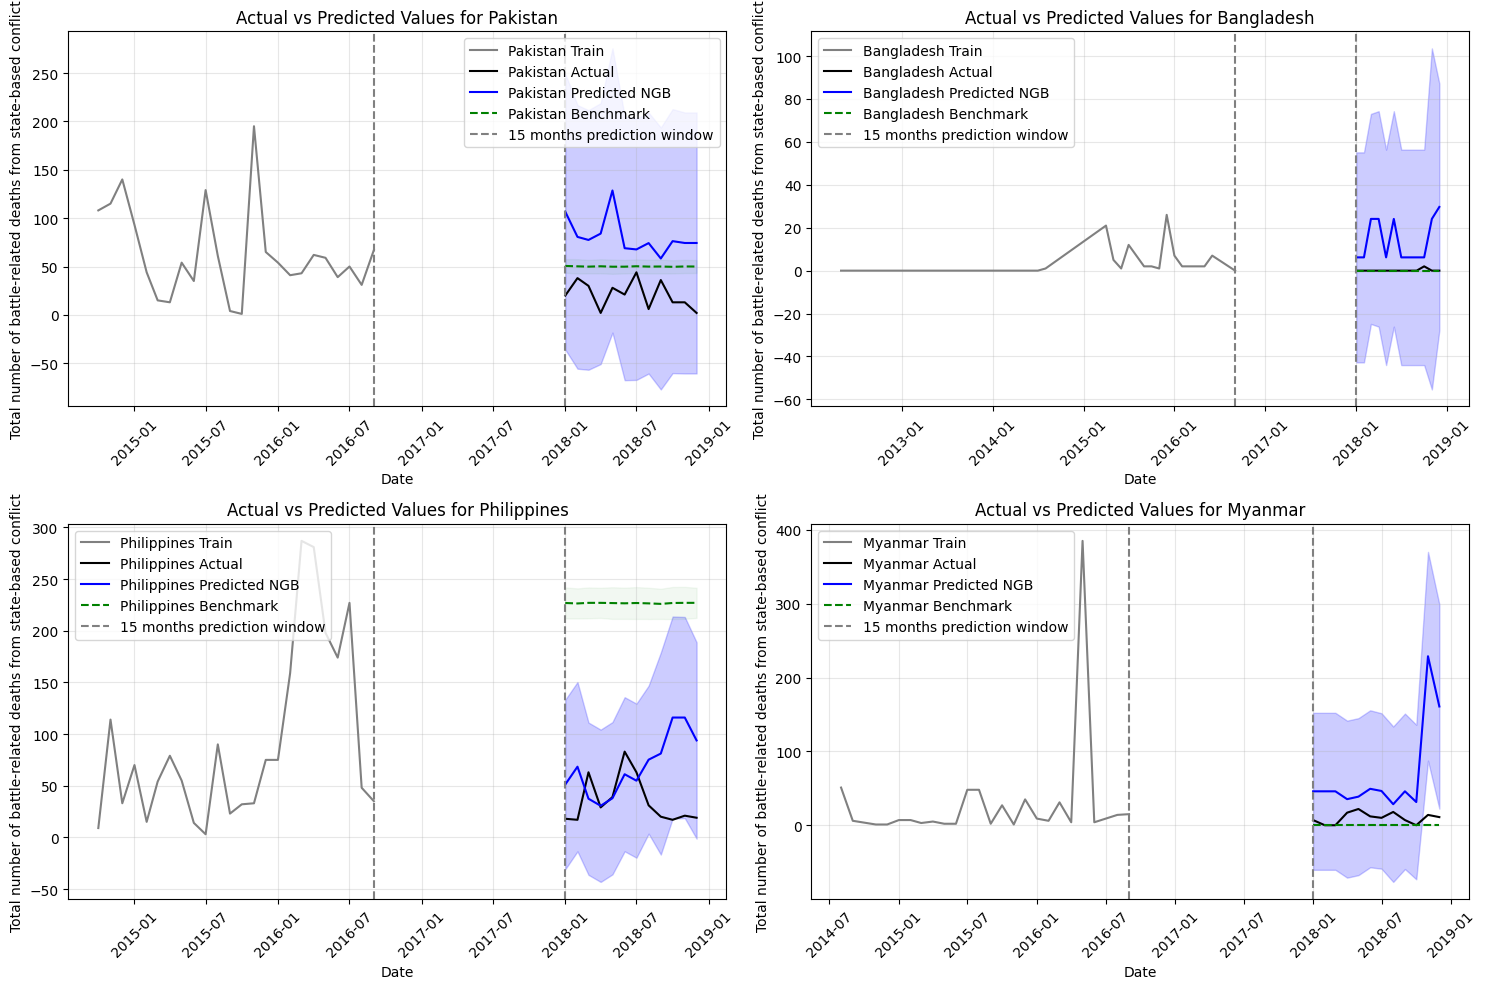

Skipping Vietnam as all actual are 0
Skipping Botswana as all actual are 0
Skipping Zambia as all actual are 0
Skipping Zimbabwe as all actual are 0
Skipping Comoros as all actual are 0
Skipping Lesotho as all actual are 0
Skipping Malawi as all actual are 0


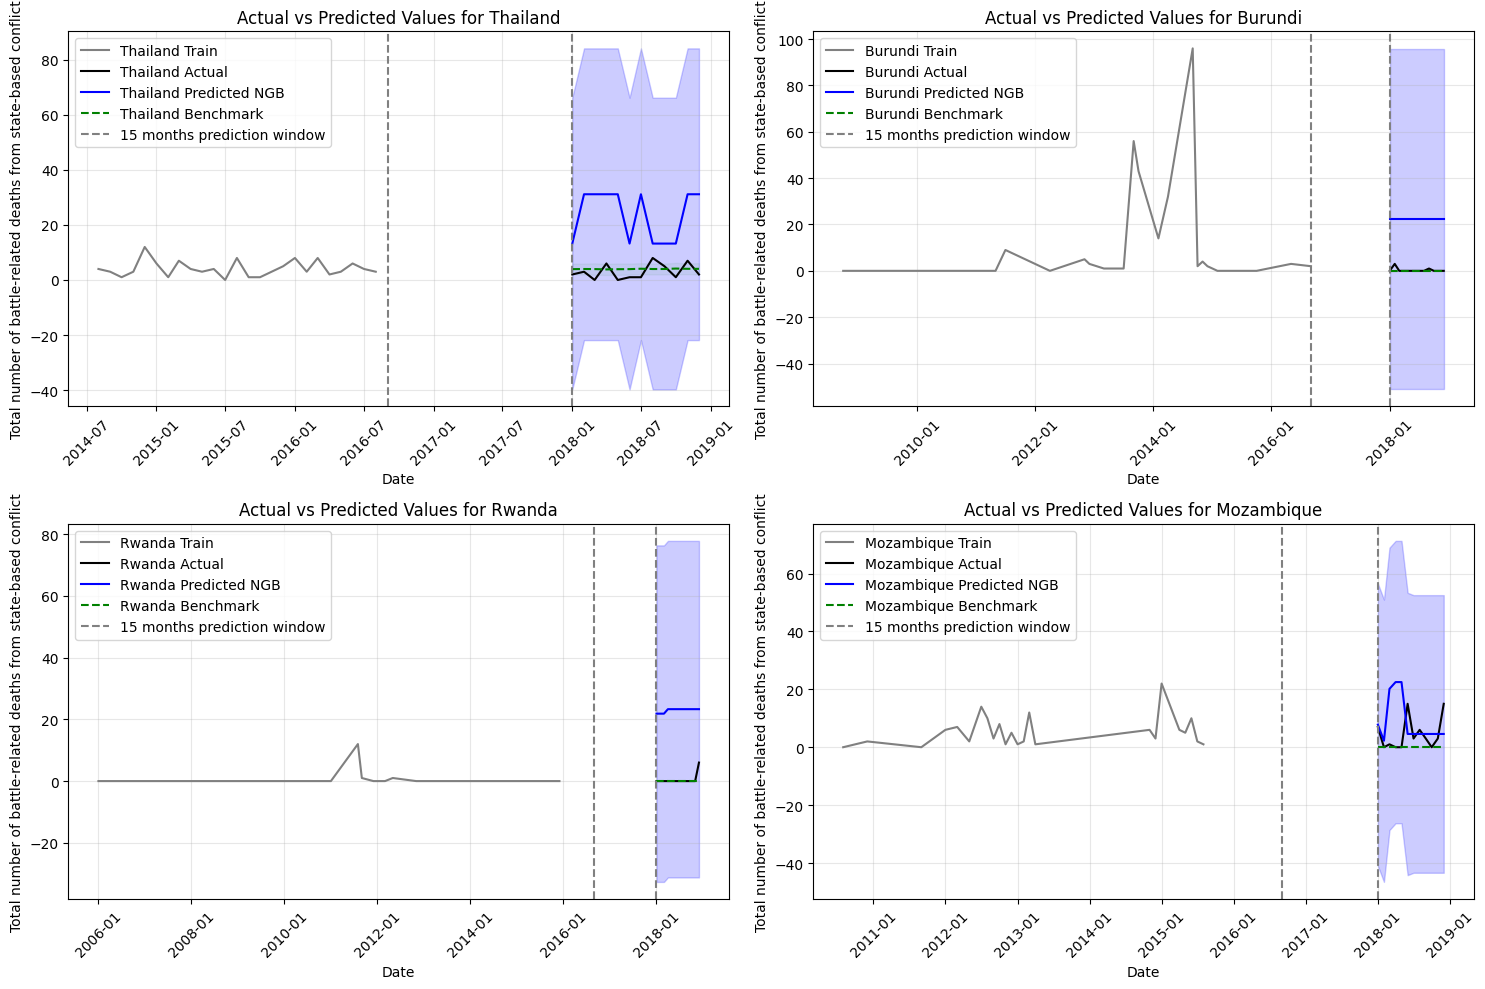

Skipping South Africa as all actual are 0
Skipping Swaziland as all actual are 0
Skipping Congo as all actual are 0
Skipping Fiji as all actual are 0
Skipping Gabon as all actual are 0
Skipping Namibia as all actual are 0
Skipping New Zealand as all actual are 0
Skipping Madagascar as all actual are 0
Skipping Mauritius as all actual are 0
Skipping Timor Leste as all actual are 0
Skipping Papua New Guinea as all actual are 0
Skipping Solomon Is. as all actual are 0
Skipping Canada as all actual are 0
Skipping Germany as all actual are 0
Skipping China as all actual are 0
Skipping Malaysia as all actual are 0
Skipping Singapore as all actual are 0


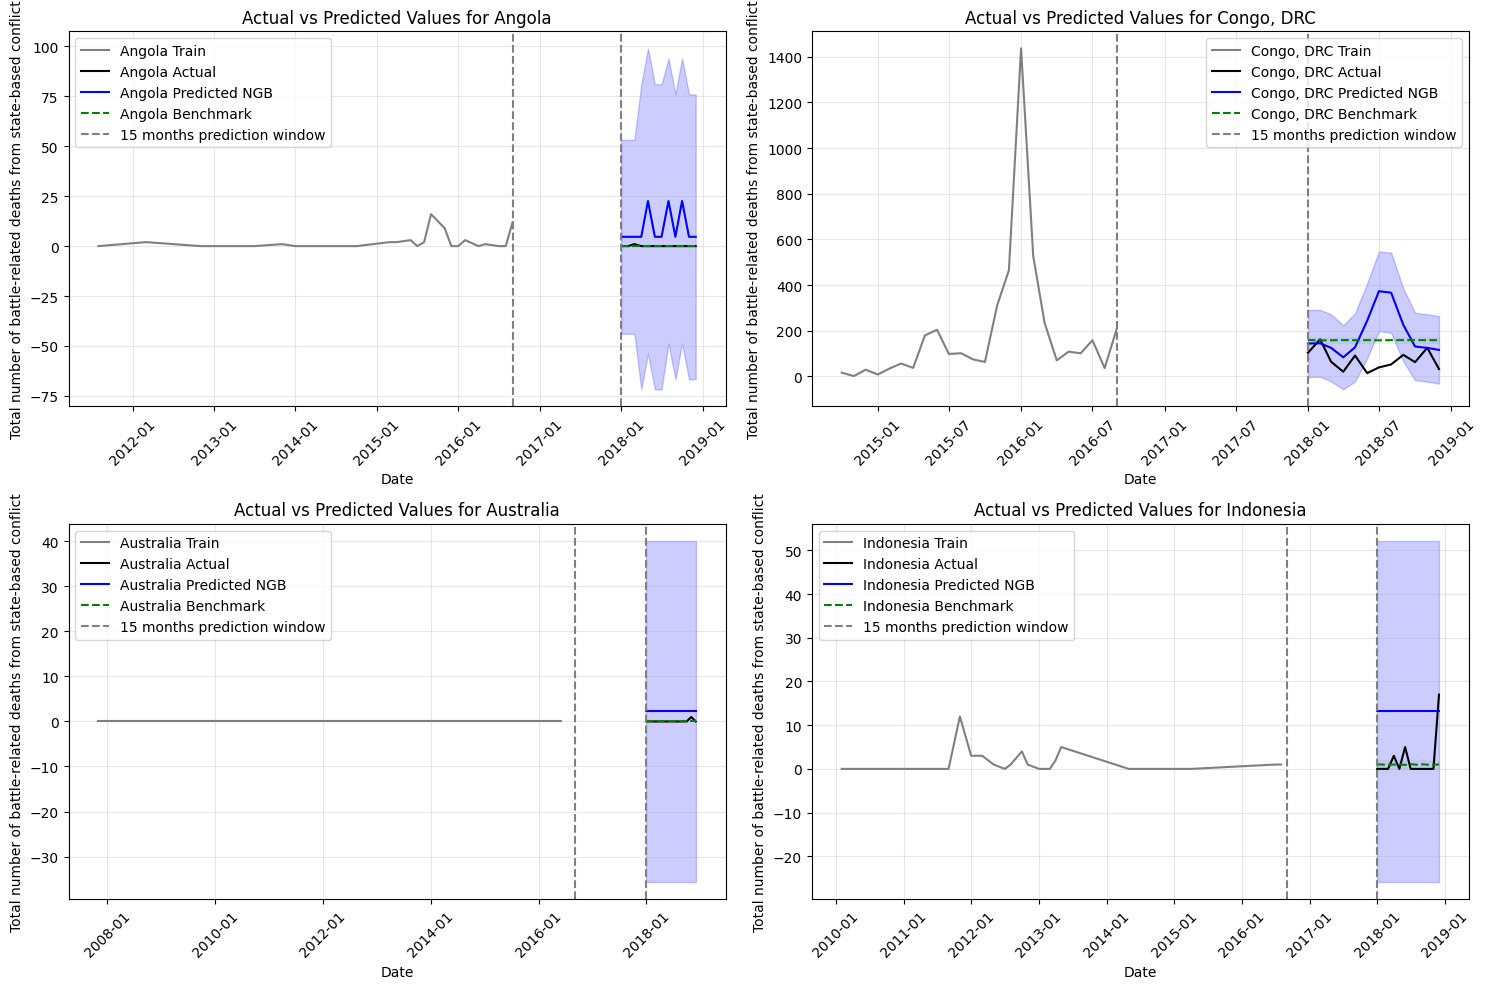

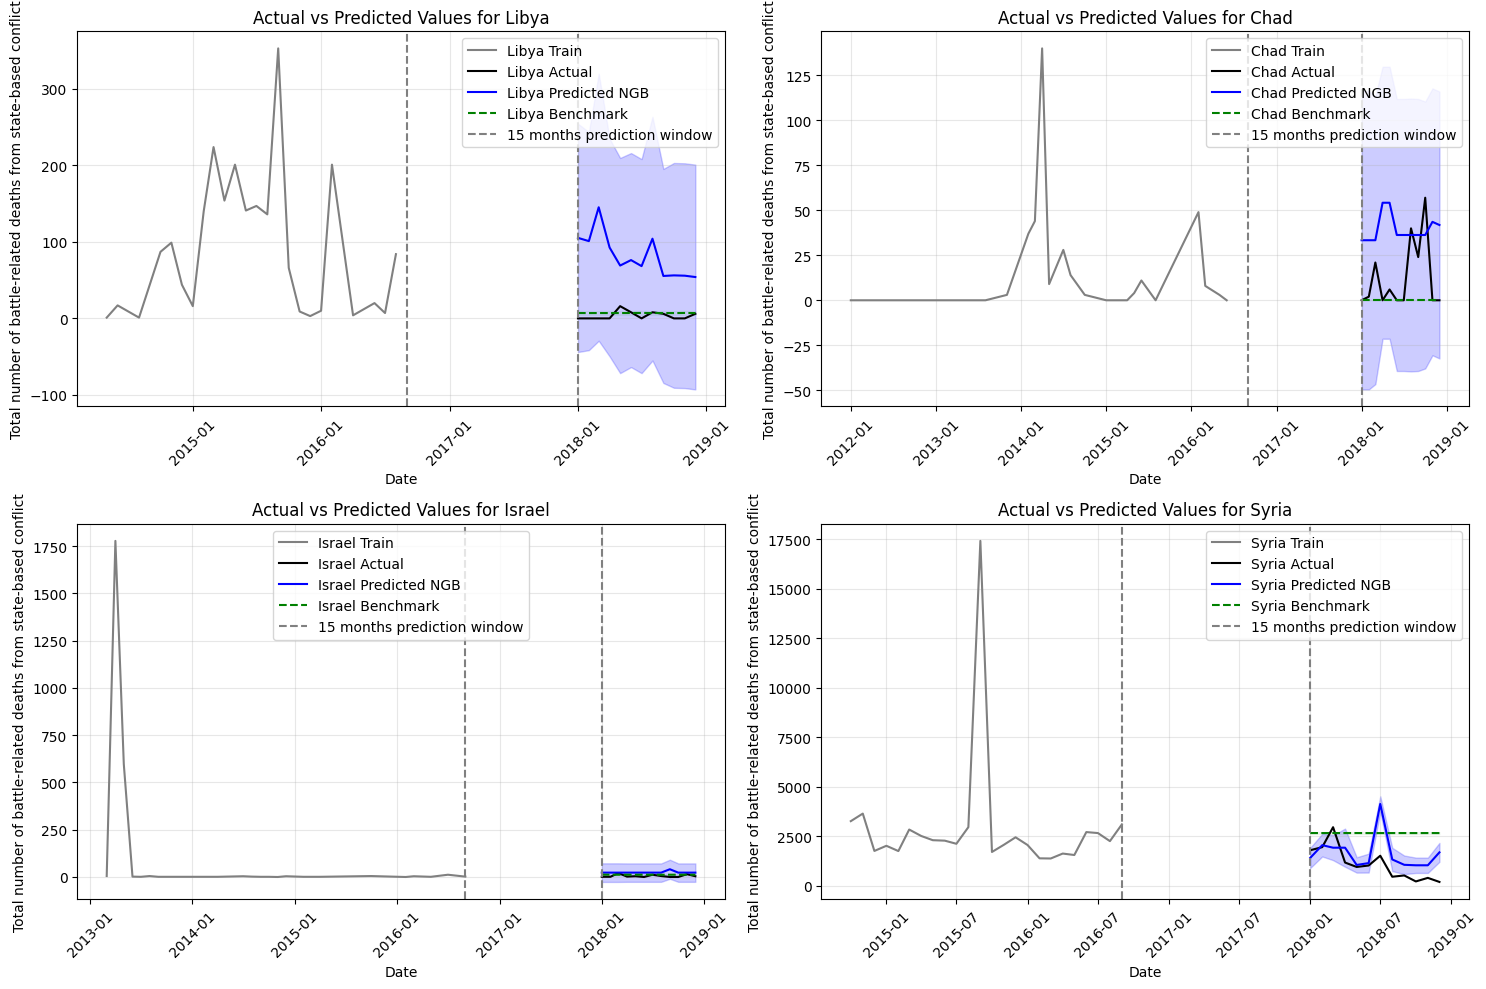

Skipping Montenegro as all actual are 0
Skipping Serbia as all actual are 0
Skipping United States as all actual are 0
Skipping Uganda as all actual are 0
Skipping Tanzania as all actual are 0
Skipping Morocco as all actual are 0
Skipping Mauritania as all actual are 0


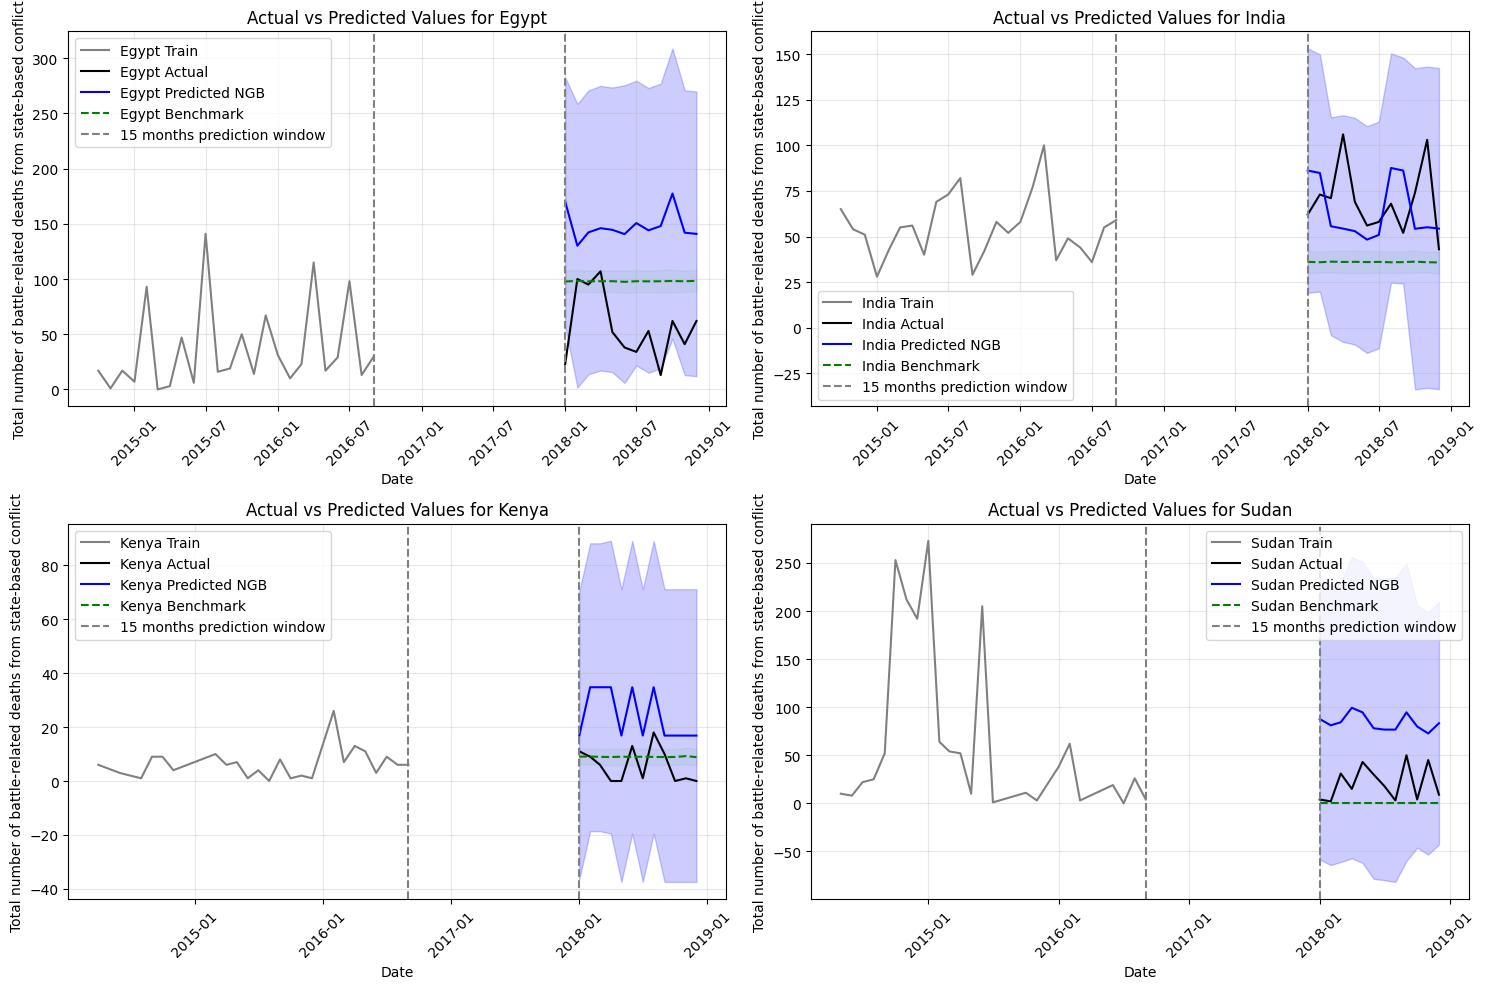

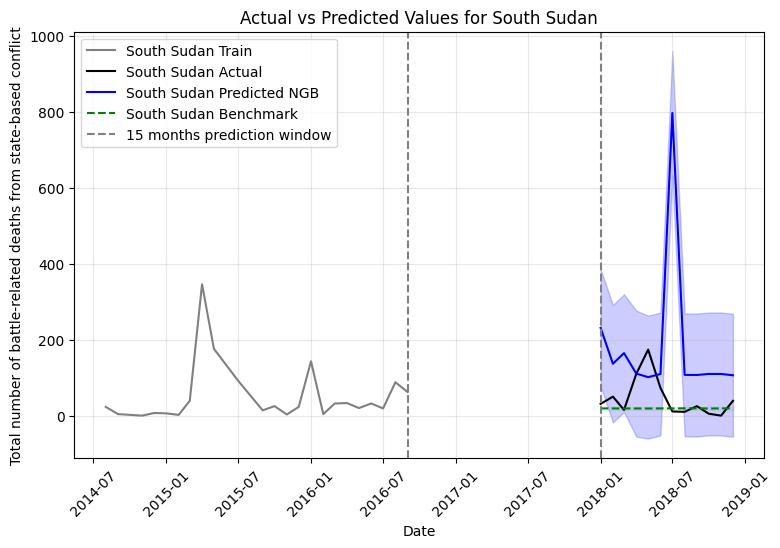

<Figure size 1500x1000 with 0 Axes>

In [703]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

# Load data
country_list = pd.read_csv('data/country_list.csv')
country_ids = test_df['country_id'].unique().tolist()

# Settings
num_plots_per_figure = 4

plt.figure(figsize=(15, 10))  # New figure
plots_added = 0
# Continue looping until all countries have been considered
max_date_train = pd.to_datetime(train_df['date'].max())
min_date_test = pd.to_datetime(test_df['date'].min())
# 1 year buffer because of validation set
expected_min_date_test = max_date_train + relativedelta(years=1 if CREATE_VAL_DS else 0,
                                                        months=15 + 1)  # 15 is window size + 1 is from Sep to Oct
print(f"Max date in training set: {max_date_train}")
print(f"Min date in test set: {min_date_test}")
print(f"Expected min date in test set: {expected_min_date_test}")
# assert the different is exactly 15 months
assert min_date_test == expected_min_date_test

for index, country_id in enumerate(country_ids):

    this_country_test = test_df[test_df['country_id'] == country_id]
    this_country_train = train_df[train_df['country_id'] == country_id]
    # get last 24 months for this_country_train
    this_country_train = this_country_train.tail(24)

    country_name = country_list[country_list['country_id'] == country_id]['name'].values[0]

    # Check if country should be skipped due to no data
    if this_country_test[target].sum() == 0:
        print(f"Skipping {country_name} as all actual are 0")
        continue

    # Prepare the subplot for non-skipped countries
    plt.subplot(2, 2, plots_added + 1)

    # Plotting data
    plt.plot(this_country_train['date'], this_country_train[target], label=f'{country_name} Train', color='gray',
             linestyle='-', marker='')
    plt.plot(this_country_test['date'], this_country_test[target], label=f'{country_name} Actual', color='black',
             linestyle='-', marker='')
    # plt.plot(this_country_test['date'], this_country_test['predictions'], label=f'{country_name} Predicted XGB',
    #          color='red', linestyle='-', marker='')
    plt.plot(this_country_test['date'], this_country_test['ngb_predictions'], label=f'{country_name} Predicted NGB',
             color='blue', linestyle='-', marker='')
    # plot std
    if PLOT_STD:
        month_max_pred = this_country_test['ngb_predictions']
        if not normal_enabled:
            plt.fill_between(this_country_test['date'],
                             this_country_test['ngb_predictions_min'],
                             this_country_test['ngb_predictions_max'],
                             color='blue',
                             alpha=0.2)
        else:
            plt.fill_between(this_country_test['date'],
                             this_country_test['ngb_predictions'] - this_country_test['ngb_predictions_std'],
                             this_country_test['ngb_predictions'] + this_country_test['ngb_predictions_std'],
                             color='blue',
                             alpha=0.2)

    # plt.plot([max_date_train, min_date_test], [-0, -0], color='gray', linestyle='-', marker='', alpha=0.5,
    #          label='15 months prediction window')

    # Benchmark plotting
    benchmark_country = benchmark_model[benchmark_model['country_id'] == country_id]
    plt.plot(benchmark_country['date'], benchmark_country['outcome'], label=f'{country_name} Benchmark',
             color='green', linestyle='--', marker='')
    plt.fill_between(benchmark_country['date'], benchmark_country['outcome'] - benchmark_country['outcome_std'],
                     benchmark_country['outcome'] + benchmark_country['outcome_std'], color='green', alpha=0.05)

    # Adding title and labels
    plt.title(f"Actual vs Predicted Values for {country_name}")
    plt.xlabel("Date")
    # turn dates 90 degrees
    plt.xticks(rotation=45)
    # make ticks more readable
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m"))
    # add vertical lines for the training and testing split
    plt.axvline(x=min_date_test, color='gray', linestyle='--', label='15 months prediction window')
    plt.axvline(x=max_date_train, color='gray', linestyle='--')
    plt.ylabel("Total number of battle-related deaths from state-based conflict")
    plt.legend()
    # add light grid
    plt.grid(alpha=0.3)

    # Increment counters
    plots_added += 1

    if plots_added % num_plots_per_figure == 0 or index == len(country_ids) - 1:
        # Adjust layout and display the figure
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(15, 10))  # New figure
        plots_added = 0

plt.show()


In [704]:
import plotly.graph_objects as go

PLOT_ONE_FIGURE = False
if PLOT_ONE_FIGURE:
    # Assuming country_list, test_df, and train_df are already loaded
    # Creating one figure for all countries
    fig = go.Figure()

    country_ids = test_df['country_id'].unique().tolist()

    for country_id in country_ids:
        # Data for this country
        this_country_test = test_df[test_df['country_id'] == country_id]
        this_country_train = train_df[train_df['country_id'] == country_id]
        country_name = country_list[country_list['country_id'] == country_id]['name'].values[0]

        # Add traces for Train Actual
        fig.add_trace(
            go.Scatter(x=this_country_train['date'], y=this_country_train[target], name=f'{country_name} Train',
                       mode='lines', line=dict(color='gray', width=1))
        )

        # Add traces for Test Actual
        fig.add_trace(
            go.Scatter(x=this_country_test['date'], y=this_country_test[target], name=f'{country_name} Test Actual',
                       mode='lines', line=dict(color='blue', width=1))
        )

        # Add traces for Predicted
        fig.add_trace(
            go.Scatter(x=this_country_test['date'], y=this_country_test['predictions'],
                       name=f'{country_name} Predicted', mode='lines', line=dict(color='red', dash='dot', width=1))
        )

    # Add figure title and adjust layout
    fig.update_layout(
        title_text="Actual vs Predicted Values Across Countries",
        xaxis_title="Date",
        yaxis_title="GED_SB Value",
        legend_title="Legend",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    # Show plot
    fig.show()

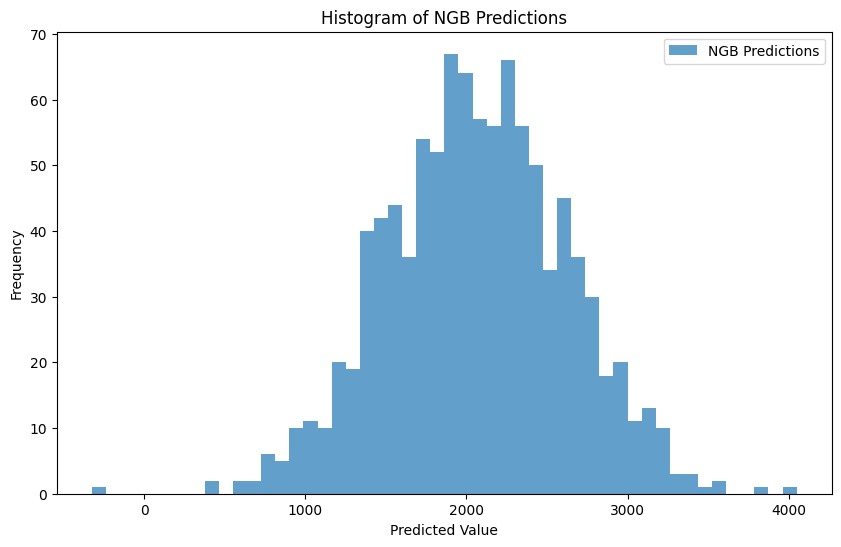

In [705]:
ngb_predictions_sampled = ngb_predictions_dist.sample(1000).T.astype(int)
# 
# concat to test_df
# test_df = pd.concat([test_df, ngb_predictions_sampled], axis=1)


# negative_mask = ngb_predictions_sampled < 0
# # print how many negative values are there
# print(negative_mask.sum().sum()) # 917442
# # print total number of values
# print(negative_mask.size) # 2028000
# # print percentage of negative values
# print(negative_mask.sum().sum() / negative_mask.size) #0.452387573964497
# # sample once more and fill in the previous negative values with values from new distribution
# ngb_predictions_sampled[negative_mask] = ngb_predictions_dist.sample(1000).T[negative_mask]
# # print again how many negative values are there
# negative_mask =  ngb_predictions_sampled < 0
# print(negative_mask.sum().sum())  # 423012

# # set 0 if negative
# # ngb_predictions_sampled = ngb_predictions_sampled.clip(min=0)
# ngb_predictions_sampled = ngb_predictions_sampled
# 
# 
# # plot histogram of the sampled predictions using plt
plt.figure(figsize=(10, 6))
plt.hist(ngb_predictions_sampled[325], bins=50, alpha=0.7, label='NGB Predictions')  # MAX
# plot a dot for the actual value
# plt.scatter([actuals_model['ged_sb'].max()], [0], color='red', label='Actual Value')
# plt.hist(ngb_predictions_sampled[20], bins=50, alpha=0.7, label='NGB Predictions') # MIN
plt.title('Histogram of NGB Predictions')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# ngb_predictions_sampled[0]

In [706]:

# len(set(benchmark_model['country_id'].unique()) - set(test_df['country_id'].unique()))
print(benchmark_model['month_id'].unique())
print(test_df['month_id'].unique())
print("Adjusted month_id for predictions:", test_df['month_id'].unique() + 15)
set(benchmark_model['month_id'].unique()) == set(test_df['month_id'].unique() + 15)

[457 458 459 460 461 462 463 464 465 466 467 468]
[442 443 444 445 446 447 448 449 450 451 452 453]
Adjusted month_id for predictions: [457 458 459 460 461 462 463 464 465 466 467 468]


True

In [707]:
test_df.index

RangeIndex(start=0, stop=2028, step=1)

In [708]:
# temp = test_df
# temp.reset_index(inplace=False, drop=False)
# 
# # get row with the highest number of deaths
# temp[temp['predictions'] == temp['predictions'].max()]
# print(temp[temp['predictions'] == temp['predictions'].min()])

# NOTE !!!!
# test_df.reset_index(inplace=True, drop=True)
test_df_edge = test_df.shape[1]
test_df_new = pd.concat([test_df, pd.DataFrame(ngb_predictions_sampled)], axis=1)
ngb_predictions_sampled[12] == test_df_new.iloc[12, test_df_edge:]

# get the row with the highest number of deaths
# actuals_model


# add to test_df_new the actuals based on month_id and country_id
# actuals_model.rename(columns={'ged_sb': 'actuals'}, inplace=True)
# test_df_new.merge(actuals_model[['month_id', 'country_id', 'actuals']], on=['month_id', 'country_id'])

# drop level 0 and index columns
# test_df.drop(columns=['level_0', 'index'], inplace=True, errors='ignore')
# test_df_new

0      True
1      True
2      True
3      True
4      True
       ... 
995    True
996    True
997    True
998    True
999    True
Name: 12, Length: 1000, dtype: bool

In [709]:
# actuals_model.rename(columns={'ged_sb': 'actuals'}, inplace=True)
# actuals_model.set_index(['month_id', 'country_id'], inplace=True)
# test_df_new.set_index(['month_id', 'country_id'], inplace=True)

In [710]:
# actuals_model.rename(columns={'ged_sb': 'actuals'}, inplace=True)
# test_df_new.reset_index(inplace=True, drop=True)
# actuals_model.reset_index(inplace=True, drop=True)


# drop actuals if it exists
# test_df_new = test_df_new.drop(columns='actuals', errors='ignore')

# join actuals to test_df_new
# test_df_new = test_df_new.join(actuals_model['actuals'], how='left')
# test_df_new.reset_index(inplace=True)
# actuals_model.reset_index(inplace=True)
# test_df_new
# actuals_model['actuals']
# test_df_new.head(10)
# test_df_new.head(1000)

In [711]:
print(list(test_df_new.columns).index(target))
print(len(test_df_new.columns))
print(test_df_edge)
test_df_new.head(100)[['month_id', 'country_id', target, 'ngb_predictions']]

125
1135
135


,month_id,country_id,y_shifted,ngb_predictions
0,442,1,0.0,2.888420
1,442,2,0.0,2.234251
2,442,3,0.0,2.234251
3,442,4,0.0,30.737823
4,442,7,0.0,2.234251
...,...,...,...,...
95,442,121,0.0,14.861646
96,442,122,0.0,42.971004
97,442,123,0.0,6.250552
98,442,124,362.0,192.020675


In [712]:
# test_df_edge = test_df_new.shape[1]
# test_df_new = pd.concat([test_df_new, pd.DataFrame(ngb_predictions_sampled)], axis=1)
# ngb_predictions_sampled[1] == test_df_new.iloc[1, test_df_edge:]

In [713]:
# get id of test_df_new[target].max()
indices_to_plot = [test_df_new[target].idxmax(), test_df_new[target].idxmin()]
indices_to_plot.extend(highest_error_indices)

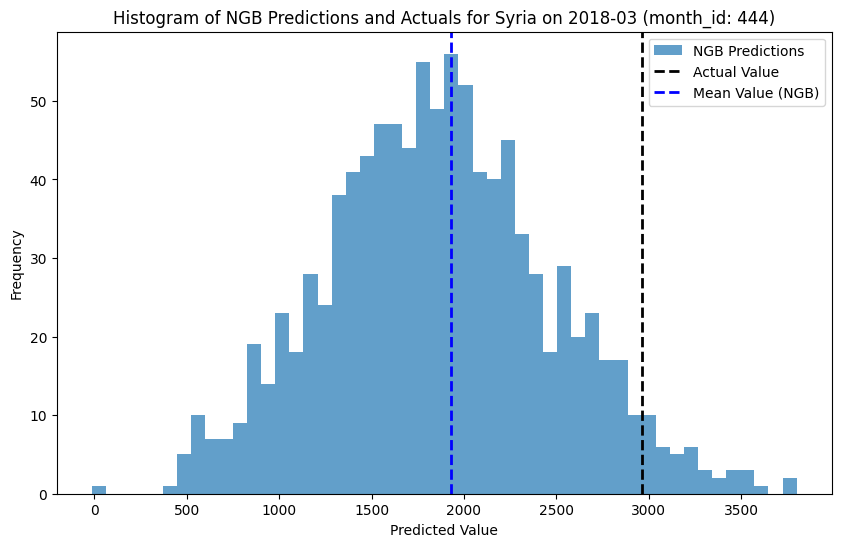

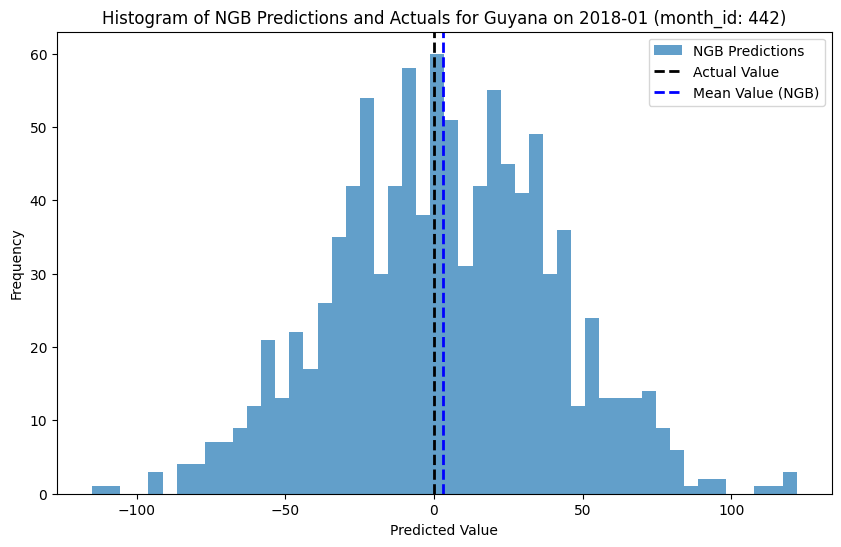

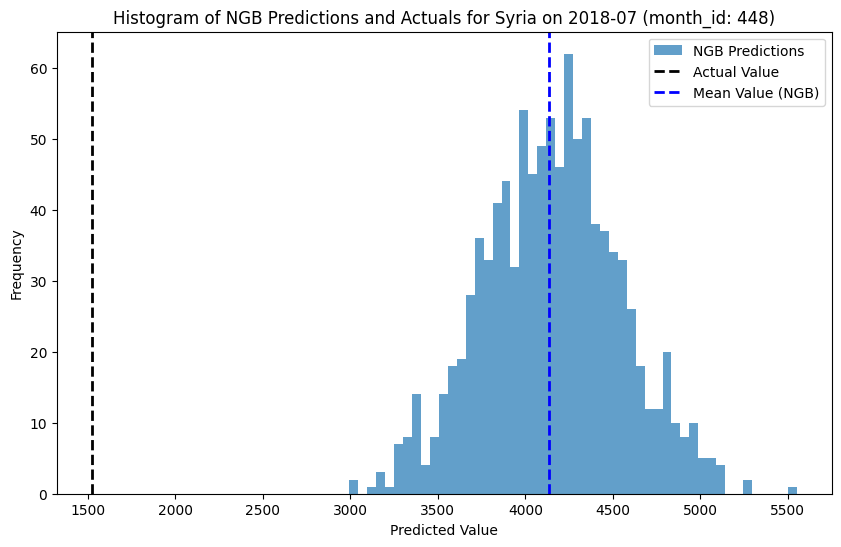

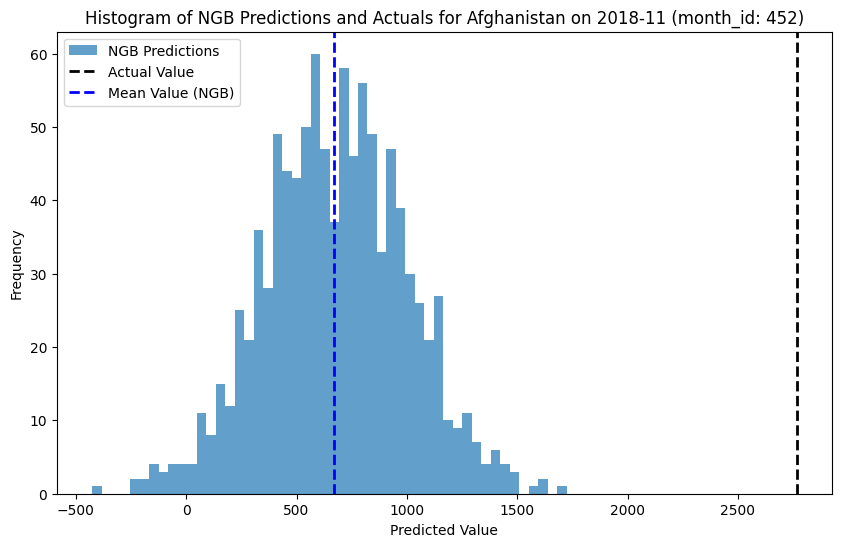

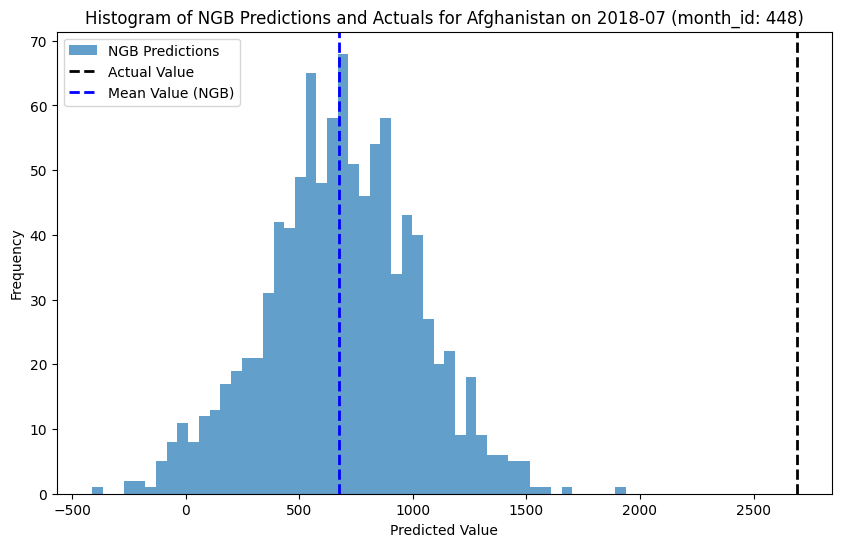

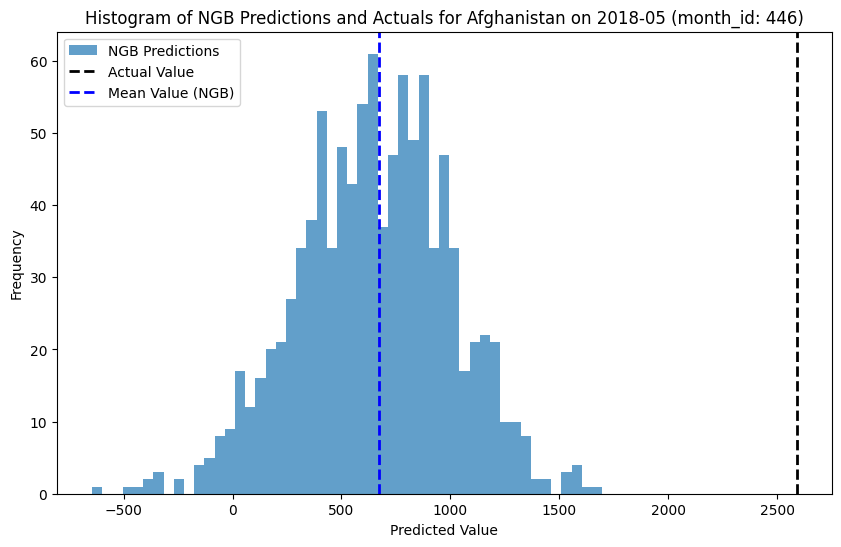

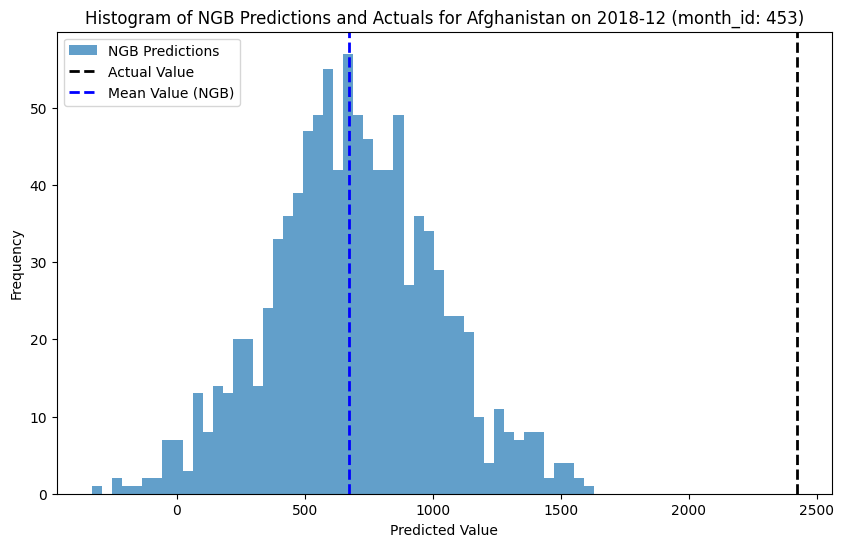

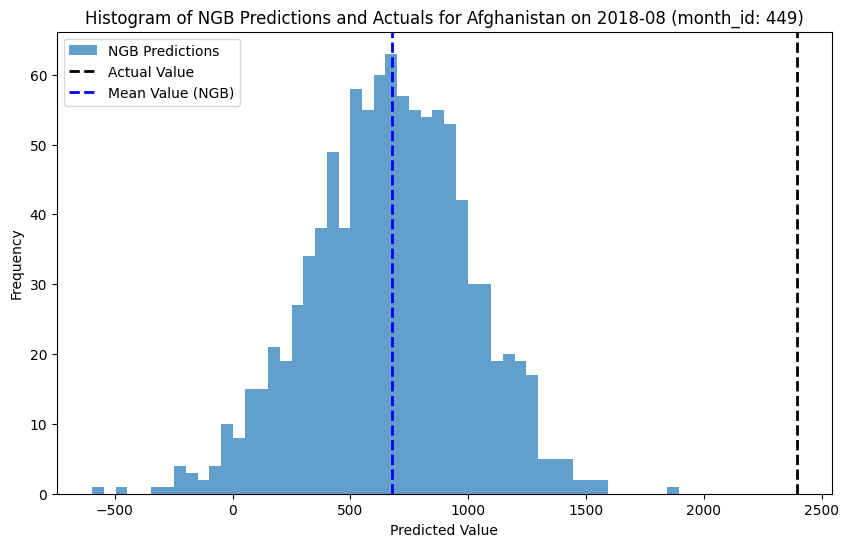

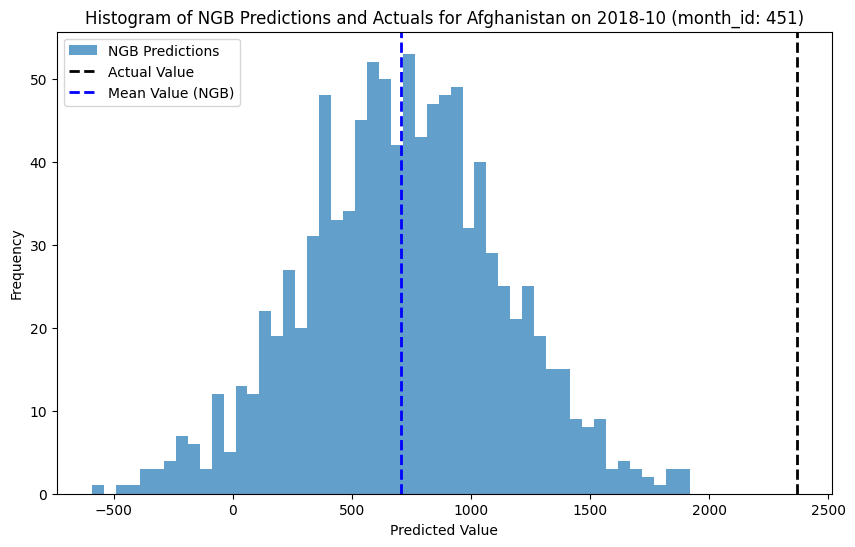

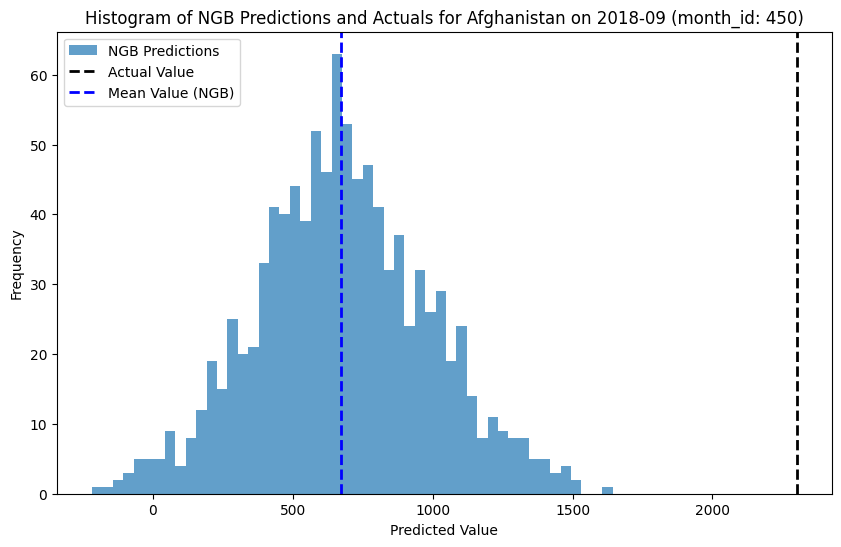

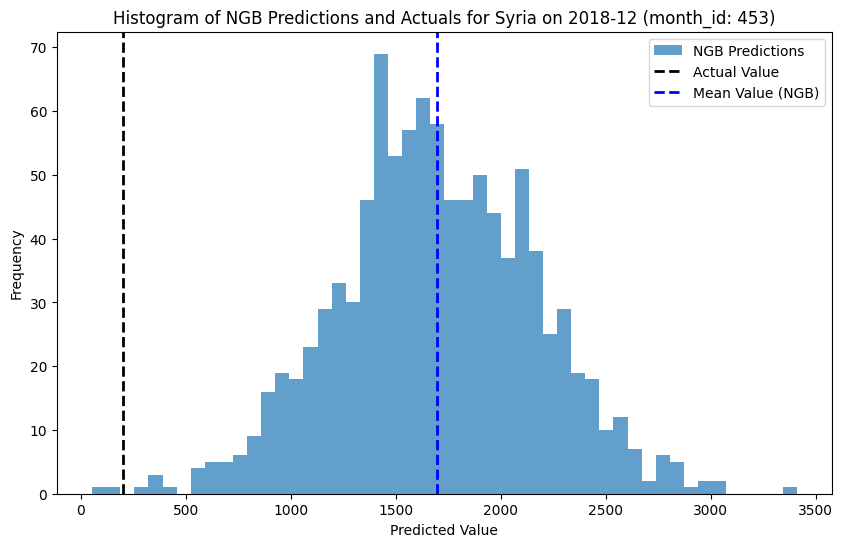

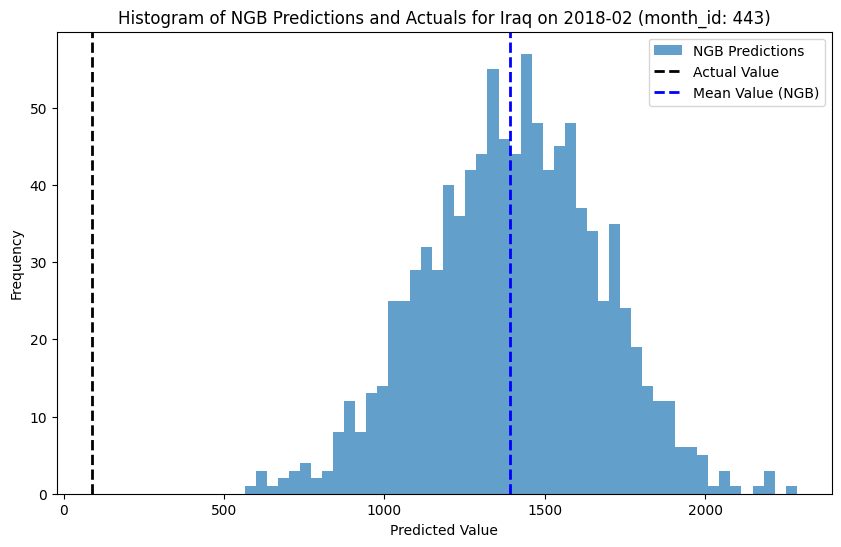

In [714]:

for index_id in indices_to_plot:
    rowww = test_df_new.iloc[[index_id]]
    actual_pred = rowww[target].values[0]
    hist_data_temp = rowww.iloc[:, test_df_edge:].values[0]
    # keep only samples that are in 95% confidence interval

    # Plot histogram of the sampled predictions using plt
    plt.figure(figsize=(10, 6))
    plt.hist(hist_data_temp, bins=50, alpha=0.7, label='NGB Predictions')

    # Plot vertical lines for actual value, mean value, and other relevant predictions
    plt.axvline(x=actual_pred, color='black', linestyle='dashed', linewidth=2, label='Actual Value')
    plt.axvline(x=rowww['ngb_predictions'].values[0], color='blue', linestyle='dashed', linewidth=2,
                label='Mean Value (NGB)')
    # plt.axvline(x=rowww['predictions'].values[0], color='red', linestyle='dashed', linewidth=2, label='XGBoost Prediction')
    formatted_date = rowww['date'].dt.strftime('%Y-%m').values[0]
    country_name = rowww['country_name'].values[0]
    plt.title(
        f'Histogram of NGB Predictions and Actuals for {country_name} on {formatted_date} (month_id: {int(rowww["month_id"].values[0])})')
    plt.xlabel('Predicted Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [715]:
test_df_new[test_df_new[target] == test_df_new[target].max()]['ngb_predictions']

494    1929.279324
Name: ngb_predictions, dtype: float64

In [716]:
rowww[['month_id', 'country_id', target, 'ngb_predictions']]

,month_id,country_id,y_shifted,ngb_predictions
214,443,60,89.0,1391.221717


In [717]:
dist_name = 'normal' if normal_enabled else 'poisson'
prediction_year

2018

In [718]:
SAVE_PREDICTIONS = True
if SAVE_PREDICTIONS:

    # Save predictions
    import numpy as np
    import os

    # TODO: for countries that are in actuals but not in the predictions, add them to the predictions with 0
    #  test_df['country_id'].unique()
    #  actuals_model['country_id'].unique()
    missing_countries = set(benchmark_model['country_id'].unique()) - set(test_df_new['country_id'].unique())

    # save predictions to a csv file
    # for each month for each country create 20 draws of the prediction named outcome
    # the structure of the file should be month_id, country_id, draw, outcome
    new_predictions_list = []
    all_countries = set(test_df_new['country_id'].unique()).union(missing_countries)
    for month_id in test_df_new['month_id'].unique():
        for country_id in all_countries:
            this_country_month = test_df_new[
                (test_df_new['month_id'] == month_id) & (test_df_new['country_id'] == country_id)]

            if country_id in missing_countries:
                outcomes = np.zeros(1000)
            else:
                outcomes = this_country_month.iloc[:, test_df_edge:].values[0]

                # remove all values smaller than 0
                non_negatives = outcomes[outcomes >= 0]
                negative_counts = np.sum(outcomes < 0)

                if negative_counts > 0:
                    # Sample from the non-negative distribution to replace negative values
                    # We assume the distribution of non-negatives is suitable for sampling
                    sampled_values = np.random.choice(non_negatives, size=negative_counts)
                    outcomes[outcomes < 0] = sampled_values

            new_predictions_list.extend([{
                'month_id': month_id + 15,  # adjust for prediction window
                'country_id': country_id,
                'draw': draw,
                'outcome': outcome
            } for draw, outcome in enumerate(outcomes, start=0)])

    # set month_id, country_id, draw as int and outcome as float
    new_predictions = pd.DataFrame(new_predictions_list)
    new_predictions['month_id'] = new_predictions['month_id'].astype(int)
    new_predictions['country_id'] = new_predictions['country_id'].astype(int)
    new_predictions['draw'] = new_predictions['draw'].astype(int)
    new_predictions['outcome'] = new_predictions['outcome'].astype(int)
    # set index to month_id, country_id, draw
    new_predictions.set_index(['month_id', 'country_id', 'draw'], inplace=True)
    # create folder if it does not exist recursively
    folder = f"submission/ng_boost_{dist_name}_d_{DROP_0_ROWS_PERCENT}_n_{n_estimators}/cm/window=Y{prediction_year}"
    os.makedirs(folder, exist_ok=True)
    new_predictions.to_parquet(
        folder + f'/ng_boost_{dist_name}_d_{DROP_0_ROWS_PERCENT}_n_{n_estimators}_Y{prediction_year}.parquet')
    print(f"Predictions saved")


Predictions saved
